In [ ]:
!pip -q install rasterio geopandas shapely pyproj folium matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 129.0 MB/s eta 0:00:00


In [ ]:
# Clean up any existing installations to avoid conflicts
!pip -q uninstall -y segmentation-models-pytorch timm pretrainedmodels efficientnet-pytorch
!pip -q install --upgrade pip

# PyTorch (CUDA 12.1 – For A100)
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Install SMP without dependencies, then add required ones individually
!pip -q install segmentation-models-pytorch==0.3.3 --no-deps
!pip -q install timm==0.9.16 pretrainedmodels==0.7.4 efficientnet_pytorch==0.7.1 --no-deps

# Check installations
import torch, segmentation_models_pytorch as smp, timm, pretrainedmodels, efficientnet_pytorch
print("CUDA:", torch.cuda.is_available(), "|", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "-")
print("SMP:", smp.__version__, "| timm:", timm.__version__, "| pretrainedmodels:", pretrainedmodels.__version__,
      "| efficientnet_pytorch:", efficientnet_pytorch.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pretrainedmodels' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pretrainedmodels'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'efficientnet_pytorch' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [ ]:
from pathlib import Path
import re
import rasterio as rio
from rasterio.merge import merge

# ==== PATHS (adjust as needed) ====
# Main folder containing S2 & LABEL GeoTIFFs
RAW_DATA_DIRECTORY = Path("/content/drive/MyDrive/greenVSgrey")
# Project root (tiles etc. will be written here)
PROJECT_ROOT_DIRECTORY = Path("/content/greenVSgreyProject")

# Regex to capture YYYY_QX (position in filename doesn't matter)
YEAR_QUARTER_REGEX = re.compile(r"_(\d{4})_(Q[1-4])", re.IGNORECASE)

def list_available_periods(raw_data_dir: Path = RAW_DATA_DIRECTORY):
    """Extracts unique YYYY_QX periods from .tif files in RAW_DATA_DIRECTORY."""
    year_quarters = set()
    # Recursively glob for .tif files
    for file_path in raw_data_dir.rglob("*.tif"):
        match = YEAR_QUARTER_REGEX.search(file_path.name)
        if match:
            # Format as YYYY_QX (uppercase Q)
            year_quarters.add(f"{match.group(1)}_{match.group(2).upper()}")
    # Sort by year and then quarter
    return sorted(year_quarters, key=lambda s: (int(s[:4]), s[-2:]))

def _get_matching_files(prefix_and_yq: str, raw_data_dir: Path = RAW_DATA_DIRECTORY):
    """Gets .tif files matching a base like 's2_2025_Q3' or 'label_2024_Q1'."""
    base_name = prefix_and_yq.lower()
    matching_files = []
    # Recursively glob for .tif files
    for file_path in raw_data_dir.rglob("*.tif"):
        file_name = file_path.name.lower()
        # Check if filename starts with base or contains base followed by '-'
        if file_name.startswith(base_name) or (base_name in file_name and file_name.split(base_name, 1)[-1].startswith("-")):
            matching_files.append(file_path)
    return sorted(matching_files)

def open_and_process_raster(prefix_and_yq: str, raw_data_dir: Path = RAW_DATA_DIRECTORY):
    """
    Opens matching .tif(s). Reads directly if single, mosaics if multiple.
    Returns: (arr, profile) -> arr shape=(C, H, W)
    """
    files_to_process = _get_matching_files(prefix_and_yq, raw_data_dir)
    # Ensure matching files were found
    if not files_to_process:
        raise FileNotFoundError(f"No matching .tif found: {prefix_and_yq} (RAW={raw_data_dir})")

    if len(files_to_process) == 1:
        with rio.open(files_to_process[0]) as src:
            raster_array = src.read()          # (C, H, W)
            raster_profile = src.profile        # Rasterio profile(the profile refers to a dictionary containing the metadata of a raster dataset.)
        return raster_array, raster_profile
    else:
        # Open all source files
        source_rasters = [rio.open(p) for p in files_to_process]
        try:
            # Merge into a single mosaic
            mosaic_array, mosaic_transform = merge(source_rasters)   # (C, H, W)
            mosaic_profile = source_rasters[0].profile            # Get profile from the first source
            # Update profile with new transform, height, and width
            mosaic_profile.update(transform=mosaic_transform, height=mosaic_array.shape[1], width=mosaic_array.shape[2])
            return mosaic_array, mosaic_profile
        finally:
            # Close all source files
            for src in source_rasters:
                src.close()


**Patch Extraction**

In [ ]:
'''Create image and label patches from S2 and 3-band labels'''

import numpy as np
from pathlib import Path
from tqdm import tqdm

# ==== DIRECTORIES / SETTINGS ====
# Project root (tiles etc. will be written here)
PROJECT_ROOT_DIRECTORY = Path("/content/greenVSgreyProject")
# Output directory for all tiles
TILES_DIRECTORY = PROJECT_ROOT_DIRECTORY / "tiles"
# Output directory for image patches (C, H, W, float32)
IMAGE_DIRECTORY = TILES_DIRECTORY / "images"
# Output directory for 4-class label patches (H, W, uint8, 0..3)
LABEL_DIRECTORY_4_CLASS = TILES_DIRECTORY / "labels4"

# Create output directories if they don't exist
for directory in (IMAGE_DIRECTORY, LABEL_DIRECTORY_4_CLASS):
    directory.mkdir(parents=True, exist_ok=True)

# Patch size (height and width)
PATCH_SIZE = 256
# Stride for sliding window
STRIDE_SIZE = 256
# Skip patches where the 4-class label is entirely background (class 0)
SKIP_BACKGROUND_ONLY_PATCHES = True

# Indices of bands to keep from the S2 GeoTIFF
# Assumes S2 export is [B02, B03, B04, B08, B11, B12, NDVI, NDWI, NDBI]
# Keeping the first 6 bands: B02..B12
BAND_INDICES_TO_KEEP = (0, 1, 2, 3, 4, 5)  # 0-based index

def convert_label_stack_to_4class(label_stack: np.ndarray) -> np.ndarray:
    """
    Converts a 3-band label stack [GREEN, GRAY, WATER] from GEE
    to a single-band 4-class label (0:bg, 1:green, 2:gray, 3:water).
    - Assumes bands are binary (0 or 1).
    - Priority: WATER > GREEN > GRAY.
    """
    assert label_stack.ndim == 3 and label_stack.shape[0] == 3, \
        f"Expected 3 bands for label (GREEN, GRAY, WATER): shape={label_stack.shape}"

    green_mask = (label_stack[0] > 0)
    gray_mask  = (label_stack[1] > 0)
    water_mask = (label_stack[2] > 0)

    # Initialize with background (0)
    four_class_label = np.zeros(green_mask.shape, dtype=np.uint8)
    # Assign classes based on priority
    four_class_label[gray_mask]  = 2
    four_class_label[green_mask] = 1
    four_class_label[water_mask] = 3   # Water takes precedence

    return four_class_label

def save_patches_for_period(year_quarter: str):
    """
    Reads S2 and LABEL data for a given YYYY_QX and generates patches.
    Saving scheme:
      images/{yq}_{r:05d}_{c:05d}.npy
      labels4/{yq}_{r:05d}_{c:05d}.npy
    """
    # Load S2 data (multi-band)
    s2_data, s2_profile = open_and_process_raster(f"s2_{year_quarter}", RAW_DATA_DIRECTORY)
    # Load Label data (3 bands: GREEN, GRAY, WATER)
    # Use the function from data_io.py
    label_data, label_profile = open_and_process_raster(f"label_{year_quarter}", RAW_DATA_DIRECTORY)

    # Check for spatial alignment
    assert s2_profile["transform"] == label_profile["transform"] and s2_profile["crs"] == label_profile["crs"], \
        f"Alignment mismatch for period: {year_quarter}"

    # Select desired bands from S2 data
    num_s2_bands = s2_data.shape[0]
    bands_to_keep = [i for i in BAND_INDICES_TO_KEEP if i < num_s2_bands]
    full_image_data = s2_data.astype(np.float32)
    selected_image_data = full_image_data[bands_to_keep]  # (C_keep, H, W)

    # Convert 3-band label to 4-class label
    four_class_label = convert_label_stack_to_4class(label_data)

    # Get dimensions
    height, width = s2_profile["height"], s2_profile["width"]

    # Get existing patch stems to avoid reprocessing
    existing_stems = {p.stem for p in IMAGE_DIRECTORY.glob(f"{year_quarter}_*.npy")} & \
                     {p.stem for p in LABEL_DIRECTORY_4_CLASS.glob(f"{year_quarter}_*.npy")}

    new_patch_count = 0
    existing_patch_count = 0
    background_skipped_count = 0

    # Iterate through the image using a sliding window
    for row in range(0, height - PATCH_SIZE + 1, STRIDE_SIZE):
        for col in range(0, width - PATCH_SIZE + 1, STRIDE_SIZE):
            # Create a unique identifier for the patch
            patch_tag = f"{year_quarter}_{row:05d}_{col:05d}"

            # Skip if patch already exists
            if patch_tag in existing_stems:
                existing_patch_count += 1
                continue

            # Extract image and label patches
            image_patch = selected_image_data[:, row:row+PATCH_SIZE, col:col+PATCH_SIZE]
            label_patch = four_class_label[row:row+PATCH_SIZE, col:col+PATCH_SIZE]

            # Skip if only background and SKIP_BACKGROUND_ONLY_PATCHES is True
            if SKIP_BACKGROUND_ONLY_PATCHES and label_patch.max() == 0:
                background_skipped_count += 1
                continue

            # Save the patches
            np.save(IMAGE_DIRECTORY / f"{patch_tag}.npy", image_patch)      # float32
            np.save(LABEL_DIRECTORY_4_CLASS / f"{patch_tag}.npy", label_patch)      # uint8 (0..3)
            new_patch_count += 1

    return {"new": new_patch_count, "exists": existing_patch_count, "bg_skipped": background_skipped_count}

# Main function to list periods and save patches.
# Use the function from data_io.py
available_periods = list_available_periods(RAW_DATA_DIRECTORY)
assert available_periods, f"No periods found in RAW_DATA_DIRECTORY: {RAW_DATA_DIRECTORY}"
print("Found periods (first/last):", available_periods[:5], "...", available_periods[-5:])

summary = {}
# Process each period and save patches
for yq in tqdm(available_periods, desc="Extracting patches"):
    summary[yq] = save_patches_for_period(yq)

# Calculate total counts
total_new_patches  = sum(v["new"] for v in summary.values())
total_existing_patches = sum(v["exists"] for v in summary.values())
total_background_skipped = sum(v["bg_skipped"] for v in summary.values())

print(f"\nSummary:")
print(f"New patches created: {total_new_patches:,}")
print(f"Patches that already existed: {total_existing_patches:,}")
print(f"Background-only patches skipped: {total_background_skipped:,}")
print(f"Image patches saved to => {IMAGE_DIRECTORY}")
print(f"Label patches saved to => {LABEL_DIRECTORY_4_CLASS}")

Found periods (first/last): ['2018_Q1', '2018_Q2', '2018_Q3', '2018_Q4', '2019_Q1'] ... ['2024_Q4', '2025_Q1', '2025_Q2', '2025_Q3', '2025_Q4']


Extracting patches: 100%|██████████| 32/32 [23:02<00:00, 43.19s/it]


Summary:
New patches created: 23,040
Patches that already existed: 0
Background-only patches skipped: 0
Image patches saved to => /content/greenVSgreyProject/tiles/images
Label patches saved to => /content/greenVSgreyProject/tiles/labels4


**Helper Functions**

In [ ]:
# Helper functions for calculating spectral indices and combining bands

import numpy as np

def get_year_from_stem(filename_stem: str) -> int:
    """Extracts the year from the beginning of the filename stem."""
    return int(filename_stem.split("_", 1)[0])

def calculate_spectral_indices(six_band_data: np.ndarray) -> np.ndarray:
    """
    Calculates NDVI, NDWI, and NDBI from 6 bands of S2 data.
    Assumes input order: [B02, B03, B04, B08, B11, B12]
    Returns a numpy array of shape (3, H, W) containing [NDVI, NDWI, NDBI].
    """
    # Ensure input has 6 bands
    assert six_band_data.shape[0] == 6, f"Expected 6 bands, but got {six_band_data.shape[0]}"

    # Extract original bands by their assumed index in the 6-band array
    # This assumes the 6-band data is in the order B02, B03, B04, B08, B11, B12
    B02, B03, B04, B08, B11, B12 = six_band_data

    eps = 1e-6 # Small epsilon to avoid division by zero

    # Calculate derived indices
    ndvi = (B08 - B04) / (B08 + B04 + eps)
    ndwi = (B03 - B08) / (B03 + B08 + eps)
    ndbi = (B11 - B08) / (B11 + B08 + eps)

    # Stack the indices
    return np.stack([ndvi, ndwi, ndbi], axis=0) # (3, H, W)

def calculate_9_bands_from_6(six_band_data: np.ndarray) -> np.ndarray:
    """
    Calculates NDVI, NDWI, and NDBI from 6 bands of S2 data and concatenates them.
    Assumes input order: [B02, B03, B04, B08, B11, B12].
    Returns a numpy array of shape (9, H, W) containing [B02..B12, NDVI, NDWI, NDBI].
    """
    # Ensure input has 6 bands
    assert six_band_data.shape[0] == 6, f"Expected 6 bands for calculating 9 bands, but got {six_band_data.shape[0]}"

    # Calculate derived indices using the helper function
    derived_indices = calculate_spectral_indices(six_band_data) # (3, H, W)

    # Concatenate the original 6 bands with the 3 derived indices
    return np.concatenate([six_band_data, derived_indices], axis=0) # (9, H, W)

Neden mean/std'yi 6 bant + (lokal) NDVI/NDWI/NDBI üzerinden hesaplıyoruz?

- Tutarlılık: NDVI/NDWI/NDBI GEE'den değil, 6 ham S2 banttan (B02,B03,B04,B08,B11,B12)
  yerelde aynı formülle (aynı epsilon ve tip) üretilir. Böylece eğitimde gördüğümüz dağılımla
  inference’ta gördüğümüz dağılım birebir örtüşür → domain shift riski azalır.

- Zaman/Maliyet & Depolama: GEE’den 9 bant indirmek daha fazla kota, bant genişliği ve disk ister.
  6 bant indirip indeksleri lokalde türetmek hem daha hafif IO’dur hem de disk kullanımını ~%33 azaltır.

- Esneklik: İndeks tanımlarını/eşiklerini değiştirmek istediğimizde GEE export’u yenilemeden
  sadece bu yerel hesap kısmını güncellememiz yeterlidir.

- Reprodüksiyon: Mean/std, eğitimde kullanılan aynı yerel indeks üretimiyle hesaplandığı için
  eğitim ve çıkarımda normalize edilen veri dağılımı aynıdır. Bu, modelin kararlılığını ve
  yeniden üretilebilirliğini artırır.

Özet: 6 ham bandı temel alıp NDVI/NDWI/NDBI’yi yerelde üretmek; tutarlılık, hız/depoya tasarruf,
esneklik ve reprodüksiyon açısından daha güvenli ve ekonomiktir.

**Calculating STD and MEAN**

In [ ]:
'''Compute mean/std for 9 bands (6 bands + NDVI + NDWI + NDBI)'''

from pathlib import Path
import numpy as np
from tqdm import tqdm

# Assuming PROJECT_ROOT_DIRECTORY is defined in the previous cell

# Use the consistent project root from previous cells
IMAGE_TILES_DIRECTORY = PROJECT_ROOT_DIRECTORY / "tiles" / "images"
BAND_MEAN_FILEPATH = PROJECT_ROOT_DIRECTORY / "band_mean.npy"
BAND_STD_FILEPATH  = PROJECT_ROOT_DIRECTORY / "band_std.npy"

# ==== MAIN COMPUTATION ====
# Filter files for training data (year 2023 or earlier).
image_files = sorted([p for p in IMAGE_TILES_DIRECTORY.glob("*.npy") if get_year_from_stem(p.stem) <= 2023])
assert image_files, "No training patches (year <= 2023) found."

sum_of_values = np.zeros(9, dtype=np.float64)
sum_of_squares = np.zeros(9, dtype=np.float64)
total_pixels = 0

# Iterate through image files and accumulate statistics
for file_path in tqdm(image_files, desc="Computing stats"):
    image_data_6_bands = np.load(file_path).astype(np.float64)  # (6, H, W)
    # Handle potential NaN/inf values by converting to zero
    image_data_6_bands = np.nan_to_num(image_data_6_bands, nan=0.0, posinf=0.0, neginf=0.0)

    # Calculate derived indices using the new function
    derived_indices = calculate_spectral_indices(image_data_6_bands) # (3, H, W)

    # Combine original bands with derived indices
    image_data_9_bands = np.concatenate([image_data_6_bands, derived_indices], axis=0)  # (9, H, W)

    # Reshape data to easily compute sum and sum of squares per band
    flattened_data = image_data_9_bands.reshape(9, -1)

    # Accumulate sums and sum of squares
    sum_of_values  += flattened_data.sum(axis=1)
    sum_of_squares += (flattened_data**2).sum(axis=1)
    total_pixels += flattened_data.shape[1] # Add number of pixels in this patch

# Calculate mean and standard deviation
mean_values = sum_of_values / total_pixels
variance_values  = sum_of_squares / total_pixels - mean_values**2
# Ensure variance is non-negative before taking square root
std_values  = np.sqrt(np.maximum(variance_values, 1e-12))

# Save the computed statistics
np.save(BAND_MEAN_FILEPATH, mean_values.astype(np.float32))
np.save(BAND_STD_FILEPATH,  std_values.astype(np.float32))

print("Computed Mean:", mean_values)
print("Computed Std :", std_values)
print("Saved Mean to:", BAND_MEAN_FILEPATH)
print("Saved Std to :", BAND_STD_FILEPATH)


Computing stats: 100%|██████████| 17280/17280 [03:11<00:00, 90.04it/s]

Computed Mean: [ 6.07819282e+02  7.34423892e+02  7.07825213e+02  1.74087801e+03
  1.41457912e+03  1.02171603e+03  2.59860213e-01 -1.87308986e-01
 -1.13898086e-01]
Computed Std : [4.43344732e+02 5.21214936e+02 6.47335399e+02 1.32130544e+03
 1.04604185e+03 8.65453016e+02 3.64177299e-01 4.27017616e-01
 1.58671696e-01]
Saved Mean to: /content/greenVSgreyProject/band_mean.npy
Saved Std to : /content/greenVSgreyProject/band_std.npy


**Saving MEAN and STD to Drive**

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the project directory in Colab where mean and std files are saved
PROJECT_ROOT = "/content/greenVSgreyProject" # Make sure this matches the path used in your other cells

# Define the destination directory in Google Drive
DRIVE_SAVE_DIR = "/content/drive/MyDrive/greenVSgrey_stats" # Change this to your desired folder name in Drive

# Create the destination directory in Drive if it doesn't exist
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

# Copy the mean and std files using shell command
print(f"Copying mean and std files from {PROJECT_ROOT} to {DRIVE_SAVE_DIR}")
os.system(f'cp {PROJECT_ROOT}/band_mean.npy {DRIVE_SAVE_DIR}/')
os.system(f'cp {PROJECT_ROOT}/band_std.npy {DRIVE_SAVE_DIR}/')

print("\nMean and Std saving process completed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying mean and std files from /content/greenVSgreyProject to /content/drive/MyDrive/greenVSgrey_stats

Mean and Std saving process completed.


**Defining Loss Functions For Training And Inference**

In [ ]:
def iou_per_class(predictions: torch.Tensor, ground_truth: torch.Tensor, num_classes: int = 4):
    """Calculates Intersection over Union (IoU) for each class."""
    iou_list = []
    for c in range(num_classes):
        pred_mask = (predictions == c)
        gt_mask = (ground_truth == c)
        intersection = (pred_mask & gt_mask).sum().item()
        union = (pred_mask | gt_mask).sum().item()
        iou_list.append(intersection / (union + 1e-9)) # Add epsilon to avoid division by zero
    return iou_list

def dice_per_class(predictions: torch.Tensor, ground_truth: torch.Tensor, num_classes: int = 4):
    """Calculates Dice coefficient for each class."""
    dice_list = []
    for c in range(num_classes):
        pred_mask = (predictions == c)
        gt_mask = (ground_truth == c)
        intersection = (pred_mask & gt_mask).sum().item()
        denominator = pred_mask.sum().item() + gt_mask.sum().item()
        dice_list.append((2 * intersection) / (denominator + 1e-9)) # Add epsilon to avoid division by zero
    return dice_list

**UNET Training**

In [ ]:
'''Train 4-class U-Net (9-channel input: 6 bands + NDVI + NDWI + NDBI)'''
# Includes Early Stopping and ReduceLROnPlateau

import random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Assuming PROJECT_ROOT is defined in a previous cell
# Import helper functions from the cell containing spectral index calculations
# This assumes calculate_9_bands_from_6 is defined in a cell above this one

# ==== PATHS / CONSTANTS ====
PROJECT_ROOT = Path("/content/greenVSgreyProject") # Ensure this path is correctly defined or imported
IMAGE_DIR = PROJECT_ROOT / "tiles" / "images" # Directory containing image patches (6-band .npy)
LABEL_DIR = PROJECT_ROOT / "tiles" / "labels4"    # Directory containing 4-class label patches (.npy)
MEAN_FILEPATH = PROJECT_ROOT / "band_mean.npy"   # Path to the computed mean (9-element array)
STD_FILEPATH  = PROJECT_ROOT / "band_std.npy"     # Path to the computed std (9-element array)
CHECKPOINT_BEST_FILEPATH = PROJECT_ROOT / "unet4_best.pt"   # Path to save the best model checkpoint
CHECKPOINT_LAST_FILEPATH = PROJECT_ROOT / "unet4_last.pt" # Path to save the last model checkpoint

BATCH_SIZE = 6
NUM_EPOCHS = 80               
LEARNING_RATE = 1e-3
NUM_WORKERS = 2
# Class weights to handle class imbalance (e.g., boost gray, decrease background)
CLASS_WEIGHTS = torch.tensor([0.7, 1.0, 1.4, 1.2], dtype=torch.float32)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42

# Early stopping parameters
PATIENCE_EARLY_STOPPING = 10            # Number of epochs to wait for improvement before stopping
# LR scheduler parameters
SCHEDULER_PATIENCE = 4
SCHEDULER_FACTOR = 0.5
SCHEDULER_MIN_LR = 1e-6

# Set random seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)


def apply_augmentation(image: torch.Tensor, label: torch.Tensor):
    """Applies random horizontal and vertical flips, and intensity adjustments."""
    if random.random() < 0.5:
        image = torch.flip(image, dims=[2]) # Flip width (horizontal)
        label = torch.flip(label, dims=[1]) # Flip width (horizontal)
    if random.random() < 0.5:
        image = torch.flip(image, dims=[1]) # Flip height (vertical)
        label = torch.flip(label, dims=[0]) # Flip height (vertical)

    # Apply intensity augmentations only to positive values (assuming reflectance/indices)
    image_pos = torch.clamp(image, min=0.0)

    # Gamma correction
    if random.random() < 0.3:
        gamma = 0.9 + 0.2 * random.random() # Gamma between 0.9 and 1.1
        image = torch.clamp(image_pos ** gamma, min=0.0)

    # Brightness and contrast
    if random.random() < 0.3:
        alpha = 0.9 + 0.2 * random.random() # Alpha between 0.9 and 1.1
        beta = (random.random() * 0.02) - 0.01 # Beta between -0.01 and 0.01
        image = torch.clamp(image * alpha + beta, min=0.0)

    return image, label

# ==== DATASET ====
class PatchDataset(Dataset):
    """Custom Dataset for loading image and label patches."""
    def __init__(self, split="train", mean=None, std=None):
        self.mean = torch.tensor(mean, dtype=torch.float32)[:,None,None]  # Reshape for broadcasting (9,1,1)
        self.std  = torch.tensor(std,  dtype=torch.float32)[:,None,None]

        # Find all image and label files
        image_files = sorted(IMAGE_DIR.glob("*.npy"))
        label_files = sorted(LABEL_DIR.glob("*.npy"))
        assert image_files and label_files, "No patches found in image or label directories."

        # Create a map from stem (filename without extension) to label file path
        label_map = {p.stem: p for p in label_files}
        # Pair image files with their corresponding label files based on stem
        # Only include pairs where a label file exists for the image file
        image_label_pairs = [(img_p, label_map[img_p.stem]) for img_p in image_files if img_p.stem in label_map]

        # Split data based on year
        if split == "train":
            self.pairs = [p for p in image_label_pairs if get_year_from_stem(p[0].stem) <= 2023]
        elif split == "val":
            self.pairs = [p for p in image_label_pairs if get_year_from_stem(p[0].stem) == 2024]
        elif split == "test":
            self.pairs = [p for p in image_label_pairs if get_year_from_stem(p[0].stem) >= 2025]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

        assert self.pairs, f"No examples found for split: {split}"
        self.split = split

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.pairs)

    def __getitem__(self, idx):
        """Loads and preprocesses a single sample (image and label patch)."""
        # Load 6-band image data
        six_band_image = np.load(self.pairs[idx][0]).astype(np.float32)       # (6,H,W)
        # Handle potential NaN/inf values
        six_band_image = np.nan_to_num(six_band_image, nan=0.0, posinf=0.0, neginf=0.0)

        # Load 4-class label data
        label = np.load(self.pairs[idx][1]).astype(np.uint8)         # (H,W)

        # Calculate 9 bands from the 6-band image using the shared function
        # ASSUMES calculate_9_bands_from_6 IS DEFINED IN A PREVIOUS CELL AND EXECUTED
        nine_band_image = calculate_9_bands_from_6(six_band_image)     # (9,H,W)

        # Convert to PyTorch tensors
        image_tensor = torch.from_numpy(nine_band_image)
        label_tensor = torch.from_numpy(label.astype(np.int64)) # Use Int64 for CrossEntropyLoss

        # Normalize the image data
        image_tensor = (image_tensor - self.mean) / (self.std + 1e-6)

        # Apply augmentation if in training split
        if self.split == "train":
            image_tensor, label_tensor = apply_augmentation(image_tensor, label_tensor)

        return image_tensor, label_tensor

# ==== LOSS FUNCTION & METRICS ====
class CEDiceLoss(nn.Module):
    """Combination of Cross-Entropy and Dice Loss."""
    def __init__(self, class_weights=None):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        # Dice Loss in 'multiclass' mode (macro averaging)
        self.dice_loss = smp.losses.DiceLoss(mode="multiclass")
    def forward(self, logits, y):
        return self.ce_loss(logits, y) + self.dice_loss(logits, y)

# ==== TRAINING LOOP ====
# Ensure mean and std files exist and have the correct shape
assert MEAN_FILEPATH.exists() and STD_FILEPATH.exists(), "band_mean.npy or band_std.npy not found. Please run compute_stats.py first!"
mean_stats = np.load(MEAN_FILEPATH)
std_stats = np.load(STD_FILEPATH)
assert mean_stats.shape[0] == 9 and std_stats.shape[0] == 9, "Mean/Std files must contain statistics for 9 channels!"

# Create datasets and dataloaders
train_dataset = PatchDataset("train", mean_stats, std_stats)
validation_dataset = PatchDataset("val", mean_stats, std_stats)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Initialize model
model = smp.Unet(encoder_name="resnet34", encoder_weights=None,
                 in_channels=9, classes=4).to(DEVICE)

# Define loss function and optimizer
loss_function = CEDiceLoss(class_weights=CLASS_WEIGHTS.to(DEVICE))
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE,
    min_lr=SCHEDULER_MIN_LR
)

# Initialize GradScaler for mixed precision training (if using CUDA)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

# Training loop variables
best_validation_score = -1.0
epochs_no_improve = 0

# Start training loop
for epoch in range(1, NUM_EPOCHS + 1):
    # -------- Training Phase --------
    model.train() # Set model to training mode
    training_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch} [Train]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Zero gradients
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(images)
            loss = loss_function(logits, labels)

        # Backward pass and optimization step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        training_loss += loss.item() * images.size(0) # Accumulate batch loss

    training_loss /= len(train_dataset) # Calculate average training loss

    # -------- Validation Phase --------
    model.eval() # Set model to evaluation mode
    total_iou_sum = np.zeros(4)
    total_dice_sum = np.zeros(4)
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for images, labels in validation_dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            predictions = model(images).argmax(1) # Get predicted class for each pixel

            # Calculate metrics
            iou_scores = iou_per_class(predictions.cpu(), labels.cpu())
            dice_scores = dice_per_class(predictions.cpu(), labels.cpu())

            total_iou_sum  += np.array(iou_scores) * images.size(0) # Accumulate IoU per class
            total_dice_sum += np.array(dice_scores) * images.size(0) # Accumulate Dice per class
            correct_pixels += (predictions == labels).sum().item() # Accumulate correct pixels
            total_pixels   += labels.numel() # Accumulate total pixels

    # Calculate average metrics
    mean_iou  = (total_iou_sum / len(validation_dataset)).mean()
    mean_dice = (total_dice_sum / len(validation_dataset)).mean()
    pixel_accuracy = correct_pixels / total_pixels
    # Combined score for early stopping and LR scheduling
    validation_score = (mean_iou + mean_dice) / 2.0

    # Print epoch statistics
    print(f"[Epoch {epoch}] Train Loss: {training_loss:.4f} | Val mIoU: {mean_iou:.4f} | Val mDice: {mean_dice:.4f} | Val PixAcc: {pixel_accuracy:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    # --- Learning Rate Scheduler Step ---
    scheduler.step(validation_score)

    # --- Early Stopping and Model Checkpointing ---
    if validation_score > best_validation_score:
        best_validation_score = validation_score
        epochs_no_improve = 0
        # Save the best model state
        torch.save({
            "model_state_dict": model.state_dict(),
            "mean_stats": mean_stats,
            "std_stats": std_stats
            }, CHECKPOINT_BEST_FILEPATH)
        print("Saved best model checkpoint to:", CHECKPOINT_BEST_FILEPATH)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE_EARLY_STOPPING:
            print(f"Early stopping triggered at epoch {epoch} (Best validation score: {best_validation_score:.4f})")
            break # Exit training loop

# Save the final model state after the loop finishes
torch.save({
    "model_state_dict": model.state_dict(),
    "mean_stats": mean_stats,
    "std_stats": std_stats
    }, CHECKPOINT_LAST_FILEPATH)
print("Saved last model checkpoint to:", CHECKPOINT_LAST_FILEPATH)

/tmp/ipython-input-115841860.py:208: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
Epoch 1 [Train]:   0%|          | 0/2880 [00:00<?, ?it/s]/tmp/ipython-input-115841860.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
Epoch 1 [Train]: 100%|██████████| 2880/2880 [01:39<00:00, 28.94it/s]


[Epoch 1] Train Loss: 0.4755 | Val mIoU: 0.5938 | Val mDice: 0.6728 | Val PixAcc: 0.9241 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 2 [Train]: 100%|██████████| 2880/2880 [01:32<00:00, 31.05it/s]


[Epoch 2] Train Loss: 0.3308 | Val mIoU: 0.5822 | Val mDice: 0.6613 | Val PixAcc: 0.9297 | LR: 1.00e-03


Epoch 3 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.65it/s]


[Epoch 3] Train Loss: 0.3059 | Val mIoU: 0.6423 | Val mDice: 0.7128 | Val PixAcc: 0.9427 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 4 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.58it/s]


[Epoch 4] Train Loss: 0.2794 | Val mIoU: 0.6612 | Val mDice: 0.7269 | Val PixAcc: 0.9524 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 5 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.69it/s]


[Epoch 5] Train Loss: 0.2502 | Val mIoU: 0.6417 | Val mDice: 0.7129 | Val PixAcc: 0.9410 | LR: 1.00e-03


Epoch 6 [Train]: 100%|██████████| 2880/2880 [01:31<00:00, 31.37it/s]


[Epoch 6] Train Loss: 0.2449 | Val mIoU: 0.6559 | Val mDice: 0.7221 | Val PixAcc: 0.9527 | LR: 1.00e-03


Epoch 7 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.60it/s]


[Epoch 7] Train Loss: 0.2389 | Val mIoU: 0.6741 | Val mDice: 0.7365 | Val PixAcc: 0.9574 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 8 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.88it/s]


[Epoch 8] Train Loss: 0.2299 | Val mIoU: 0.6551 | Val mDice: 0.7227 | Val PixAcc: 0.9494 | LR: 1.00e-03


Epoch 9 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.62it/s]


[Epoch 9] Train Loss: 0.2256 | Val mIoU: 0.6677 | Val mDice: 0.7325 | Val PixAcc: 0.9558 | LR: 1.00e-03


Epoch 10 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.54it/s]


[Epoch 10] Train Loss: 0.2238 | Val mIoU: 0.6671 | Val mDice: 0.7330 | Val PixAcc: 0.9514 | LR: 1.00e-03


Epoch 11 [Train]: 100%|██████████| 2880/2880 [01:36<00:00, 29.95it/s]


[Epoch 11] Train Loss: 0.2214 | Val mIoU: 0.6567 | Val mDice: 0.7241 | Val PixAcc: 0.9531 | LR: 1.00e-03


Epoch 12 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.86it/s]


[Epoch 12] Train Loss: 0.2125 | Val mIoU: 0.6767 | Val mDice: 0.7377 | Val PixAcc: 0.9582 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 13 [Train]:  50%|████▉     | 1432/2880 [00:45<00:54, 26.56it/s]/tmp/ipython-input-115841860.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
Epoch 13 [Train]:  65%|██████▌   | 1874/2880 [01:00<00:31, 31.85it/s]/tmp/ipython-input-115841860.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
Epoch 13 [Train]:  69%|██████▉   | 1990/2880 [01:04<00:27, 31.96it/s]/tmp/ipython-input-115841860.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
Epoch 13 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.50it/s]


[Epoch 13] Train Loss: 0.2055 | Val mIoU: 0.6769 | Val mDice: 0.7380 | Val PixAcc: 0.9534 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 14 [Train]:   2%|▎         | 72/2880 [00:02<01:26, 32.58it/s]/tmp/ipython-input-115841860.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
Epoch 14 [Train]:  24%|██▍       | 698/2880 [00:23<01:08, 31.72it/s]/tmp/ipython-input-115841860.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
Epoch 14 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.45it/s]


[Epoch 14] Train Loss: 0.2028 | Val mIoU: 0.6809 | Val mDice: 0.7425 | Val PixAcc: 0.9558 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 15 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.90it/s]


[Epoch 15] Train Loss: 0.2042 | Val mIoU: 0.6798 | Val mDice: 0.7407 | Val PixAcc: 0.9586 | LR: 1.00e-03


Epoch 16 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.83it/s]


[Epoch 16] Train Loss: 0.1976 | Val mIoU: 0.6590 | Val mDice: 0.7255 | Val PixAcc: 0.9487 | LR: 1.00e-03


Epoch 17 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.67it/s]


[Epoch 17] Train Loss: 0.2054 | Val mIoU: 0.6861 | Val mDice: 0.7453 | Val PixAcc: 0.9615 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 18 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.33it/s]


[Epoch 18] Train Loss: 0.1954 | Val mIoU: 0.6901 | Val mDice: 0.7483 | Val PixAcc: 0.9621 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 19 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.53it/s]


[Epoch 19] Train Loss: 0.1930 | Val mIoU: 0.6808 | Val mDice: 0.7409 | Val PixAcc: 0.9592 | LR: 1.00e-03


Epoch 20 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.38it/s]


[Epoch 20] Train Loss: 0.1933 | Val mIoU: 0.6872 | Val mDice: 0.7452 | Val PixAcc: 0.9631 | LR: 1.00e-03


Epoch 21 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.68it/s]


[Epoch 21] Train Loss: 0.1834 | Val mIoU: 0.6914 | Val mDice: 0.7497 | Val PixAcc: 0.9611 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 22 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.63it/s]


[Epoch 22] Train Loss: 0.1854 | Val mIoU: 0.6786 | Val mDice: 0.7416 | Val PixAcc: 0.9545 | LR: 1.00e-03


Epoch 23 [Train]: 100%|██████████| 2880/2880 [01:32<00:00, 30.97it/s]


[Epoch 23] Train Loss: 0.1954 | Val mIoU: 0.6945 | Val mDice: 0.7514 | Val PixAcc: 0.9643 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 24 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.44it/s]


[Epoch 24] Train Loss: 0.1858 | Val mIoU: 0.7009 | Val mDice: 0.7564 | Val PixAcc: 0.9646 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 25 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.54it/s]


[Epoch 25] Train Loss: 0.1841 | Val mIoU: 0.6746 | Val mDice: 0.7378 | Val PixAcc: 0.9576 | LR: 1.00e-03


Epoch 26 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.85it/s]


[Epoch 26] Train Loss: 0.1850 | Val mIoU: 0.6797 | Val mDice: 0.7397 | Val PixAcc: 0.9591 | LR: 1.00e-03


Epoch 27 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.85it/s]


[Epoch 27] Train Loss: 0.1902 | Val mIoU: 0.6975 | Val mDice: 0.7535 | Val PixAcc: 0.9647 | LR: 1.00e-03


Epoch 28 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.12it/s]


[Epoch 28] Train Loss: 0.1783 | Val mIoU: 0.6972 | Val mDice: 0.7536 | Val PixAcc: 0.9643 | LR: 1.00e-03


Epoch 29 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.48it/s]


[Epoch 29] Train Loss: 0.1937 | Val mIoU: 0.7051 | Val mDice: 0.7589 | Val PixAcc: 0.9665 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 30 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.89it/s]


[Epoch 30] Train Loss: 0.1865 | Val mIoU: 0.6854 | Val mDice: 0.7458 | Val PixAcc: 0.9602 | LR: 1.00e-03


Epoch 31 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.24it/s]


[Epoch 31] Train Loss: 0.1803 | Val mIoU: 0.7015 | Val mDice: 0.7557 | Val PixAcc: 0.9660 | LR: 1.00e-03


Epoch 32 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.65it/s]


[Epoch 32] Train Loss: 0.1758 | Val mIoU: 0.7081 | Val mDice: 0.7615 | Val PixAcc: 0.9666 | LR: 1.00e-03
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 33 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.08it/s]


[Epoch 33] Train Loss: 0.1772 | Val mIoU: 0.6980 | Val mDice: 0.7541 | Val PixAcc: 0.9635 | LR: 1.00e-03


Epoch 34 [Train]: 100%|██████████| 2880/2880 [01:36<00:00, 29.98it/s]


[Epoch 34] Train Loss: 0.1723 | Val mIoU: 0.7025 | Val mDice: 0.7578 | Val PixAcc: 0.9654 | LR: 1.00e-03


Epoch 35 [Train]: 100%|██████████| 2880/2880 [01:38<00:00, 29.36it/s]


[Epoch 35] Train Loss: 0.1739 | Val mIoU: 0.7056 | Val mDice: 0.7591 | Val PixAcc: 0.9669 | LR: 1.00e-03


Epoch 36 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.04it/s]


[Epoch 36] Train Loss: 0.1755 | Val mIoU: 0.7000 | Val mDice: 0.7549 | Val PixAcc: 0.9648 | LR: 1.00e-03


Epoch 37 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.64it/s]


[Epoch 37] Train Loss: 0.1771 | Val mIoU: 0.6864 | Val mDice: 0.7466 | Val PixAcc: 0.9568 | LR: 1.00e-03


Epoch 38 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.49it/s]


[Epoch 38] Train Loss: 0.1605 | Val mIoU: 0.7136 | Val mDice: 0.7649 | Val PixAcc: 0.9693 | LR: 5.00e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 39 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.80it/s]


[Epoch 39] Train Loss: 0.1634 | Val mIoU: 0.7116 | Val mDice: 0.7636 | Val PixAcc: 0.9686 | LR: 5.00e-04


Epoch 40 [Train]: 100%|██████████| 2880/2880 [01:36<00:00, 29.99it/s]


[Epoch 40] Train Loss: 0.1563 | Val mIoU: 0.7130 | Val mDice: 0.7644 | Val PixAcc: 0.9686 | LR: 5.00e-04


Epoch 41 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.52it/s]


[Epoch 41] Train Loss: 0.1571 | Val mIoU: 0.7070 | Val mDice: 0.7605 | Val PixAcc: 0.9666 | LR: 5.00e-04


Epoch 42 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.94it/s]


[Epoch 42] Train Loss: 0.1605 | Val mIoU: 0.7114 | Val mDice: 0.7632 | Val PixAcc: 0.9689 | LR: 5.00e-04


Epoch 43 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.78it/s]


[Epoch 43] Train Loss: 0.1572 | Val mIoU: 0.7143 | Val mDice: 0.7643 | Val PixAcc: 0.9697 | LR: 5.00e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 44 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.39it/s]


[Epoch 44] Train Loss: 0.1546 | Val mIoU: 0.7125 | Val mDice: 0.7646 | Val PixAcc: 0.9669 | LR: 5.00e-04


Epoch 45 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.75it/s]


[Epoch 45] Train Loss: 0.1542 | Val mIoU: 0.7160 | Val mDice: 0.7663 | Val PixAcc: 0.9695 | LR: 5.00e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 46 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.79it/s]


[Epoch 46] Train Loss: 0.1531 | Val mIoU: 0.7166 | Val mDice: 0.7673 | Val PixAcc: 0.9692 | LR: 5.00e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 47 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.24it/s]


[Epoch 47] Train Loss: 0.1549 | Val mIoU: 0.7153 | Val mDice: 0.7661 | Val PixAcc: 0.9691 | LR: 5.00e-04


Epoch 48 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.34it/s]


[Epoch 48] Train Loss: 0.1526 | Val mIoU: 0.7101 | Val mDice: 0.7624 | Val PixAcc: 0.9686 | LR: 5.00e-04


Epoch 49 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.50it/s]


[Epoch 49] Train Loss: 0.1566 | Val mIoU: 0.7171 | Val mDice: 0.7672 | Val PixAcc: 0.9705 | LR: 5.00e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 50 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.32it/s]


[Epoch 50] Train Loss: 0.1529 | Val mIoU: 0.7077 | Val mDice: 0.7610 | Val PixAcc: 0.9667 | LR: 5.00e-04


Epoch 51 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.46it/s]


[Epoch 51] Train Loss: 0.1535 | Val mIoU: 0.7162 | Val mDice: 0.7666 | Val PixAcc: 0.9701 | LR: 5.00e-04


Epoch 52 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.49it/s]


[Epoch 52] Train Loss: 0.1504 | Val mIoU: 0.7122 | Val mDice: 0.7644 | Val PixAcc: 0.9668 | LR: 5.00e-04


Epoch 53 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.44it/s]


[Epoch 53] Train Loss: 0.1526 | Val mIoU: 0.7050 | Val mDice: 0.7592 | Val PixAcc: 0.9670 | LR: 5.00e-04


Epoch 54 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.15it/s]


[Epoch 54] Train Loss: 0.1601 | Val mIoU: 0.7131 | Val mDice: 0.7644 | Val PixAcc: 0.9682 | LR: 5.00e-04


Epoch 55 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.17it/s]


[Epoch 55] Train Loss: 0.1505 | Val mIoU: 0.7220 | Val mDice: 0.7705 | Val PixAcc: 0.9714 | LR: 2.50e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 56 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.23it/s]


[Epoch 56] Train Loss: 0.1442 | Val mIoU: 0.7165 | Val mDice: 0.7670 | Val PixAcc: 0.9687 | LR: 2.50e-04


Epoch 57 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.15it/s]


[Epoch 57] Train Loss: 0.1455 | Val mIoU: 0.7218 | Val mDice: 0.7705 | Val PixAcc: 0.9715 | LR: 2.50e-04


Epoch 58 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.49it/s]


[Epoch 58] Train Loss: 0.1423 | Val mIoU: 0.7214 | Val mDice: 0.7701 | Val PixAcc: 0.9711 | LR: 2.50e-04


Epoch 59 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.37it/s]


[Epoch 59] Train Loss: 0.1440 | Val mIoU: 0.7204 | Val mDice: 0.7695 | Val PixAcc: 0.9706 | LR: 2.50e-04


Epoch 60 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.64it/s]


[Epoch 60] Train Loss: 0.1422 | Val mIoU: 0.7190 | Val mDice: 0.7688 | Val PixAcc: 0.9703 | LR: 2.50e-04


Epoch 61 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.57it/s]


[Epoch 61] Train Loss: 0.1399 | Val mIoU: 0.7214 | Val mDice: 0.7700 | Val PixAcc: 0.9710 | LR: 1.25e-04


Epoch 62 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.12it/s]


[Epoch 62] Train Loss: 0.1400 | Val mIoU: 0.7247 | Val mDice: 0.7723 | Val PixAcc: 0.9720 | LR: 1.25e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 63 [Train]: 100%|██████████| 2880/2880 [01:36<00:00, 29.90it/s]


[Epoch 63] Train Loss: 0.1383 | Val mIoU: 0.7232 | Val mDice: 0.7713 | Val PixAcc: 0.9715 | LR: 1.25e-04


Epoch 64 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.16it/s]


[Epoch 64] Train Loss: 0.1390 | Val mIoU: 0.7231 | Val mDice: 0.7714 | Val PixAcc: 0.9713 | LR: 1.25e-04


Epoch 65 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.64it/s]


[Epoch 65] Train Loss: 0.1373 | Val mIoU: 0.7242 | Val mDice: 0.7721 | Val PixAcc: 0.9715 | LR: 1.25e-04


Epoch 66 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.25it/s]


[Epoch 66] Train Loss: 0.1428 | Val mIoU: 0.7231 | Val mDice: 0.7710 | Val PixAcc: 0.9719 | LR: 1.25e-04


Epoch 67 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.20it/s]


[Epoch 67] Train Loss: 0.1379 | Val mIoU: 0.7249 | Val mDice: 0.7725 | Val PixAcc: 0.9720 | LR: 1.25e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 68 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.22it/s]


[Epoch 68] Train Loss: 0.1377 | Val mIoU: 0.7239 | Val mDice: 0.7720 | Val PixAcc: 0.9718 | LR: 1.25e-04


Epoch 69 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.29it/s]


[Epoch 69] Train Loss: 0.1367 | Val mIoU: 0.7239 | Val mDice: 0.7716 | Val PixAcc: 0.9719 | LR: 1.25e-04


Epoch 70 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.46it/s]


[Epoch 70] Train Loss: 0.1362 | Val mIoU: 0.7255 | Val mDice: 0.7728 | Val PixAcc: 0.9722 | LR: 1.25e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 71 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.03it/s]


[Epoch 71] Train Loss: 0.1372 | Val mIoU: 0.7247 | Val mDice: 0.7723 | Val PixAcc: 0.9720 | LR: 1.25e-04


Epoch 72 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.91it/s]


[Epoch 72] Train Loss: 0.1374 | Val mIoU: 0.7258 | Val mDice: 0.7731 | Val PixAcc: 0.9722 | LR: 1.25e-04
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 73 [Train]: 100%|██████████| 2880/2880 [01:32<00:00, 30.98it/s]


[Epoch 73] Train Loss: 0.1362 | Val mIoU: 0.7251 | Val mDice: 0.7725 | Val PixAcc: 0.9722 | LR: 1.25e-04


Epoch 74 [Train]: 100%|██████████| 2880/2880 [01:33<00:00, 30.66it/s]


[Epoch 74] Train Loss: 0.1353 | Val mIoU: 0.7211 | Val mDice: 0.7703 | Val PixAcc: 0.9700 | LR: 1.25e-04


Epoch 75 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.39it/s]


[Epoch 75] Train Loss: 0.1391 | Val mIoU: 0.7254 | Val mDice: 0.7724 | Val PixAcc: 0.9722 | LR: 1.25e-04


Epoch 76 [Train]: 100%|██████████| 2880/2880 [01:34<00:00, 30.63it/s]


[Epoch 76] Train Loss: 0.1393 | Val mIoU: 0.7249 | Val mDice: 0.7724 | Val PixAcc: 0.9718 | LR: 1.25e-04


Epoch 77 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.15it/s]


[Epoch 77] Train Loss: 0.1401 | Val mIoU: 0.7254 | Val mDice: 0.7727 | Val PixAcc: 0.9721 | LR: 1.25e-04


Epoch 78 [Train]: 100%|██████████| 2880/2880 [01:36<00:00, 29.92it/s]


[Epoch 78] Train Loss: 0.1329 | Val mIoU: 0.7267 | Val mDice: 0.7739 | Val PixAcc: 0.9723 | LR: 6.25e-05
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 79 [Train]: 100%|██████████| 2880/2880 [01:36<00:00, 29.88it/s]


[Epoch 79] Train Loss: 0.1331 | Val mIoU: 0.7274 | Val mDice: 0.7743 | Val PixAcc: 0.9725 | LR: 6.25e-05
Saved best model checkpoint to: /content/greenVSgreyProject/unet4_best.pt


Epoch 80 [Train]: 100%|██████████| 2880/2880 [01:35<00:00, 30.05it/s]


[Epoch 80] Train Loss: 0.1338 | Val mIoU: 0.7266 | Val mDice: 0.7734 | Val PixAcc: 0.9725 | LR: 6.25e-05
Saved last model checkpoint to: /content/greenVSgreyProject/unet4_last.pt


**UNET Model Saving To Drive**

In [ ]:
'''Save the model to drive'''

from google.colab import drive
import os

PROJECT_ROOT = "/content/greenVSgreyProject"

# Define the destination directory in Google Drive
DRIVE_SAVE_DIR = "/content/drive/MyDrive/greenVSgrey_models"

# Create the destination directory in Drive if it doesn't exist
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

# Copy the model files using shell command
print(f"Copying model files from {PROJECT_ROOT} to {DRIVE_SAVE_DIR}")
os.system(f'cp {PROJECT_ROOT}/unet4_best.pt {DRIVE_SAVE_DIR}/')
os.system(f'cp {PROJECT_ROOT}/unet4_last.pt {DRIVE_SAVE_DIR}/')

print("\nModel saving process completed.")

Copying model files from /content/greenVSgreyProject to /content/drive/MyDrive/greenVSgrey_models

Model saving process completed.


**Inference For UNET**

In [ ]:
''' UNet inference on test data (>=2025)
    Generates [RGB | Overlay | ColorMask] PNGs
    Includes optional GRAY BOOST based on NDBI/NDWI/NDBI priors'''

from pathlib import Path
import numpy as np
import torch
import cv2 # For image processing and visualization
import segmentation_models_pytorch as smp
from tqdm import tqdm
import re # For parsing filename stems

# Assuming PROJECT_ROOT_DIRECTORY is defined in a previous cell
# Assuming helper functions like calculate_spectral_indices,
# calculate_9_bands_from_6, and get_year_from_stem are defined
# in previous cells and are available in the global scope.

# ==== PATHS ====
PROJECT_ROOT = PROJECT_ROOT_DIRECTORY # Ensure consistency
IMAGE_DIR = PROJECT_ROOT / "tiles" / "images" # Directory containing image patches (6-band .npy)
LABEL_DIR = PROJECT_ROOT / "tiles" / "labels4"    # Directory containing 4-class label patches (.npy)
CHECKPOINT_FILEPATH = Path("/content/drive/MyDrive/greenVSgrey_models/unet4_best.pt")
assert CHECKPOINT_FILEPATH.exists(), f"Bulunamadı: {CHECKPOINT_FILEPATH}"
OUTPUT_DIRECTORY = PROJECT_ROOT / "inference_results" # Output directory for inference results
OUTPUT_DIRECTORY.mkdir(parents=True, exist_ok=True)

# ==== CONSTANTS ====
# Color palette for the 4 classes (BGR format for OpenCV)
PALETTE = {
    0: (0, 0, 0),     # Background (Black)
    1: (0, 255, 0),   # Green (Green)
    2: (128, 128, 128), # Gray (Gray)
    3: (255, 191, 0)  # Water
}
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- GRAY/WATER prior settings (Optional) ----
# Weights for boosting gray and water logits based on spectral indices
K_GRAY_BOOST, K_WATER_BOOST = 1.6, 1.0
# Thresholds for spectral indices to activate the boost
THRESHOLD_NDBI, THRESHOLD_NDVI, THRESHOLD_NDWI = 0.05, 0.25, 0.20

# Regex to parse filename stem (e.g., '2025_Q1_00000_00000')
# Assuming FILENAME_STEM_REGEX is defined elsewhere or used implicitly by get_year_from_stem
# FILENAME_STEM_REGEX = re.compile(r"(?P<y>\d{4})_(?P<q>Q[1-4])_(?P<r>\d{5})_(?P<c>\d{5})")

# ==== HELPER FUNCTIONS (Assuming these are defined in previous cells) ====
# def get_year_from_stem(stem: str) -> int: ...
# def calculate_spectral_indices(six_band_data: np.ndarray) -> np.ndarray: ...
# def calculate_9_bands_from_6(six_band_data: np.ndarray) -> np.ndarray: ...


def percent_stretch(channel: np.ndarray, p1: int = 2, p2: int = 98) -> np.ndarray:
    """
    Performs a percentile stretch on a single image channel.
    Clips values between p1 and p2 percentiles and scales to 0-1.
    """
    lower_percentile, upper_percentile = np.percentile(channel, [p1, p2])
    stretched_channel = np.clip((channel - lower_percentile) / (upper_percentile - lower_percentile + 1e-6), 0, 1)
    return stretched_channel

def create_rgb_image(six_band_data: np.ndarray) -> np.ndarray:
    """
    Creates an 8-bit RGB image from 6-band data (assumes B02, B03, B04 are first 3 bands)
    using percentile stretching. Returns (H, W, 3) np.uint8 array.
    """
    # Assuming input order: [B02, B03, B04, B08, B11, B12]
    # Use B04 (Red), B03 (Green), B02 (Blue) for natural color composite
    red_channel   = percent_stretch(six_band_data[2]) # B04
    green_channel = percent_stretch(six_band_data[1]) # B03
    blue_channel  = percent_stretch(six_band_data[0]) # B02

    # Stack channels and scale to 0-255, convert to uint8
    rgb_image = (np.stack([red_channel, green_channel, blue_channel], axis=2) * 255).astype(np.uint8)
    return rgb_image # (H, W, 3)

def create_color_mask(prediction: np.ndarray, palette: dict) -> np.ndarray:
    """
    Creates a color mask image from a single-band prediction mask using a palette.
    Returns (H, W, 3) np.uint8 array (BGR format).
    """
    height, width = prediction.shape
    color_mask_image = np.zeros((height, width, 3), dtype=np.uint8)
    for class_value, bgr_color in palette.items():
        color_mask_image[prediction == class_value] = bgr_color
    return color_mask_image # (H, W, 3) BGR

def overlay_images(background_rgb: np.ndarray, foreground_mask_bgr: np.ndarray, alpha: float = 0.45) -> np.ndarray:
    """
    Overlays a BGR color mask onto an RGB background image.
    Returns (H, W, 3) np.uint8 array (BGR format).
    """
    # OpenCV addWeighted expects BGR format, so convert RGB background to BGR
    background_bgr = cv2.cvtColor(background_rgb, cv2.COLOR_RGB2BGR)
    overlayed_image = cv2.addWeighted(background_bgr, 1.0, foreground_mask_bgr, alpha, 0)
    return overlayed_image # (H, W, 3) BGR

def add_spectral_priors(six_band_data: np.ndarray, logits: torch.Tensor,
                        gray_class_idx: int = 2, water_class_idx: int = 3,
                        k_gray: float = K_GRAY_BOOST, k_water: float = K_WATER_BOOST,
                        thr_ndbi: float = THRESHOLD_NDBI, thr_ndvi: float = THRESHOLD_NDVI, thr_ndwi: float = THRESHOLD_NDWI) -> torch.Tensor:
    """
    Adjusts logits for gray and water classes based on spectral index thresholds.
    Uses calculate_spectral_indices (assumed defined elsewhere).
    """
    # Calculate derived indices using the shared function
    # ASSUMES calculate_spectral_indices IS DEFINED IN A PREVIOUS CELL AND EXECUTED
    derived_indices = calculate_spectral_indices(six_band_data) # (3, H, W)
    ndvi, ndwi, ndbi = derived_indices

    # Convert numpy indices to torch tensors on the same device as logits
    t_ndvi = torch.from_numpy(ndvi).to(logits.device).unsqueeze(0)
    t_ndwi = torch.from_numpy(ndwi).to(logits.device).unsqueeze(0)
    t_ndbi = torch.from_numpy(ndbi).to(logits.device).unsqueeze(0)

    # Create prior masks based on thresholds
    # Gray prior: High NDBI AND Low NDVI AND Low NDWI
    gray_prior = (t_ndbi - thr_ndbi).clamp(min=0) * \
                 (thr_ndvi - t_ndvi).clamp(min=0) * \
                 (thr_ndwi - t_ndwi).clamp(min=0)

    # Water prior: High NDWI
    water_prior = (t_ndwi - thr_ndwi).clamp(min=0)

    # Apply boost to logits
    logits = logits.clone() # Clone to avoid modifying original logits
    logits[:, gray_class_idx]  = logits[:, gray_class_idx]  + k_gray * gray_prior
    logits[:, water_class_idx] = logits[:, water_class_idx] + k_water * water_prior

    return logits


# ==== MAIN INFERENCE LOGIC ====
# Load the trained model checkpoint
assert CHECKPOINT_FILEPATH.exists(), f"Model checkpoint not found: {CHECKPOINT_FILEPATH}"
# Load state dictionary, including mean and std used during training
checkpoint_state = torch.load(CHECKPOINT_FILEPATH, map_location="cpu", weights_only=False)
model_state_dict = checkpoint_state["model_state_dict"]
mean_stats = checkpoint_state["mean_stats"]
std_stats = checkpoint_state["std_stats"]

# Ensure loaded stats are for 9 channels
assert mean_stats.shape[0] == 9 and std_stats.shape[0] == 9, "Mean/Std stats in checkpoint must be for 9 channels!"

# Initialize the model with the same architecture as training
model = smp.Unet(encoder_name="resnet34", encoder_weights=None,
                 in_channels=len(mean_stats), classes=4).to(DEVICE)
# Load the trained weights
model.load_state_dict(model_state_dict)
# Set model to evaluation mode
model.eval()

# Prepare mean and std for normalization (reshape for broadcasting)
mean_tensor = torch.tensor(mean_stats, dtype=torch.float32)[:, None, None]
std_tensor  = torch.tensor(std_stats,  dtype=torch.float32)[:, None, None]

# Find all image patch files and filter for test data (year 2025 or later)
image_files = sorted([p for p in IMAGE_DIR.glob("*.npy") if get_year_from_stem(p.stem) >= 2025])
assert image_files, "No test patches (year >= 2025) found."

# Initialize variables to accumulate metrics for overall test set evaluation
total_iou_sum = np.zeros(4)
total_dice_sum = np.zeros(4)
total_correct_pixels = 0
total_pixels = 0
patch_count = 0

# Iterate through test image files and perform inference
for file_path in tqdm(image_files, desc="Running Inference"):
    # Load 6-band image data
    six_band_image = np.load(file_path).astype(np.float32)       # (6,H,W)
    # Handle potential NaN/inf values by converting to zero
    six_band_image = np.nan_to_num(six_band_image, nan=0.0, posinf=0.0, neginf=0.0)

    # Load ground truth label data (for evaluation and visualization)
    ground_truth_path = LABEL_DIR / file_path.name
    ground_truth_label = np.load(ground_truth_path).astype(np.uint8) # (H,W)

    # Calculate 9 bands from the 6-band image using the shared function
    # ASSUMES calculate_9_bands_from_6 IS DEFINED IN A PREVIOUS CELL AND EXECUTED
    nine_band_image = calculate_9_bands_from_6(six_band_image)     # (9,H,W)

    # Normalize the 9-band image data
    image_tensor = torch.from_numpy(nine_band_image).to(DEVICE)
    image_normalized = (image_tensor - mean_tensor.to(DEVICE)) / (std_tensor.to(DEVICE) + 1e-6)

    # Perform inference (forward pass)
    with torch.no_grad(): # Disable gradient calculation
        # Add batch dimension (1, C, H, W)
        logits = model(image_normalized.unsqueeze(0))

        # Apply spectral priors to logits (Optional)
        logits = add_spectral_priors(six_band_image, logits)

        # Get predicted class for each pixel (remove batch dimension)
        prediction = logits.argmax(1).squeeze(0).cpu().numpy().astype(np.uint8) # (H, W)

    # Calculate metrics for the current patch
    iou_scores = iou_per_class(prediction, ground_truth_label)
    dice_scores = dice_per_class(prediction, ground_truth_label)

    # Accumulate metrics
    total_iou_sum  += np.array(iou_scores)
    total_dice_sum += np.array(dice_scores)
    total_correct_pixels += (prediction == ground_truth_label).sum().item()
    total_pixels   += ground_truth_label.size
    patch_count += 1


    # ==== Visualization ====
    # Create RGB image from 6-band data
    rgb_image = create_rgb_image(six_band_image) # (H, W, 3) RGB

    # Create color mask from prediction
    color_mask_image = create_color_mask(prediction, PALETTE) # (H, W, 3) BGR

    # Create overlay image
    overlayed_image = overlay_images(rgb_image, color_mask_image, alpha=0.45) # (H, W, 3) BGR

    # Concatenate images for combined visualization [RGB | Overlay | ColorMask]
    combined_visualization = np.concatenate([rgb_image, cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB), cv2.cvtColor(color_mask_image, cv2.COLOR_BGR2RGB)], axis=1) # (H, 3*W, 3) RGB

    # Save the combined visualization image
    output_filepath = OUTPUT_DIRECTORY / f"{file_path.stem}_inference.png"
    cv2.imwrite(str(output_filepath), cv2.cvtColor(combined_visualization, cv2.COLOR_RGB2BGR)) # Save as BGR using cv2


# Calculate and print overall metrics for the test set
if patch_count > 0:
    average_iou = (total_iou_sum / patch_count).mean()
    average_dice = (total_dice_sum / patch_count).mean()
    overall_pixel_accuracy = total_correct_pixels / total_pixels if total_pixels > 0 else 0

    print(f"\nOverall Test Set Metrics:")
    print(f"  Mean IoU (mIoU): {average_iou:.4f}")
    print(f"  Mean Dice (mDice): {average_dice:.4f}")
    print(f"  Pixel Accuracy: {overall_pixel_accuracy:.4f}")
else:
    print("\nNo test patches processed.")

print(f"Inference visualization images saved to => {OUTPUT_DIRECTORY}")


Running Inference: 100%|██████████| 2880/2880 [01:23<00:00, 34.63it/s]


Overall Test Set Metrics:
  Mean IoU (mIoU): 0.5797
  Mean Dice (mDice): 0.6233
  Pixel Accuracy: 0.9715
Inference visualization images saved to => /content/greenVSgreyProject/inference_results


**Preparing Softmax For Conv3D with the results from the UNET**

In [ ]:
from pathlib import Path
import numpy as np
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm

PROJECT_ROOT = Path("/content/greenVSgreyProject")
MODEL_DIR_DRIVE = Path("/content/drive/MyDrive/greenVSgrey_models")
CHECKPOINT_FILEPATH = MODEL_DIR_DRIVE / "unet4_best.pt"
IMAGE_DIR = PROJECT_ROOT / "tiles" / "images"
OUTPUT_DIRECTORY = PROJECT_ROOT / "series" / "softmax"
OUTPUT_DIRECTORY.mkdir(parents=True, exist_ok=True)

def _to_numpy(x):
    if isinstance(x, np.ndarray): return x.astype(np.float32, copy=False)
    if torch.is_tensor(x):        return x.detach().cpu().numpy().astype(np.float32, copy=False)
    raise TypeError("Input must be a numpy array or torch tensor")

# --- LOAD CKPT (esnek anahtarlar) ---
assert CHECKPOINT_FILEPATH.exists(), f"Model checkpoint not found: {CHECKPOINT_FILEPATH}"
ckpt = torch.load(CHECKPOINT_FILEPATH, map_location="cpu", weights_only=False)

model_state_dict = ckpt.get("model_state_dict", ckpt.get("model"))
assert model_state_dict is not None, "Checkpoint doesn't contain 'model_state_dict' or 'model'."

mean_stats = _to_numpy(ckpt.get("mean_stats", ckpt.get("mean")))
std_stats  = _to_numpy(ckpt.get("std_stats",  ckpt.get("std")))
assert mean_stats.shape[0] == 9 and std_stats.shape[0] == 9, "Mean/Std must be for 9 channels."

# --- MODEL & DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(encoder_name="resnet34", encoder_weights=None,
                 in_channels=len(mean_stats), classes=4).to(device)
model.load_state_dict(model_state_dict)
model.eval()
torch.backends.cudnn.benchmark = True

# --- NORMALIZATION TENSORS (cihaz: device) ---
mean_tensor = torch.tensor(mean_stats, dtype=torch.float32)[:, None, None].to(device)
std_tensor  = torch.tensor(std_stats,  dtype=torch.float32)[:, None, None].to(device)

# --- FILES ---
image_files = sorted(IMAGE_DIR.glob("*.npy"))
assert image_files, f"No image patches found in: {IMAGE_DIR}"

# --- LOOP ---
with torch.inference_mode():
    for file_path in tqdm(image_files, desc="Exporting softmax"):
        out_fp = OUTPUT_DIRECTORY / f"{file_path.stem}.npy"
        if out_fp.exists():
            continue

        x6 = np.load(file_path).astype(np.float32)
        x6 = np.nan_to_num(x6, nan=0.0, posinf=0.0, neginf=0.0)

        # varsayım: bu fonksiyon zaten tanımlı
        x9 = calculate_9_bands_from_6(x6).astype(np.float32)   # (9,H,W)

        x = torch.from_numpy(x9).to(device)
        x = (x - mean_tensor) / (std_tensor + 1e-6)
        x = x.unsqueeze(0)  # (1,9,H,W)

        logits = model(x)                     # (1,4,H,W)
        softmax = torch.softmax(logits, 1)[0] # (4,H,W)
        sm_np = softmax.cpu().numpy().astype(np.float32)
        np.save(out_fp, sm_np)

print(f"\nSoftmax export completed. Outputs saved to => {OUTPUT_DIRECTORY}")


Exporting softmax: 100%|██████████| 23040/23040 [04:54<00:00, 78.22it/s]


Softmax export completed. Outputs saved to => /content/greenVSgreyProject/series/softmax


**Saving the Softmaxes to Drive**

In [ ]:
from google.colab import drive
import os
from pathlib import Path # Import Path

# Define the path to the softmax output directory in Colab
PROJECT_ROOT = Path("/content/greenVSgreyProject") # Convert to Path object
SOFTMAX_DIR = PROJECT_ROOT / "series" / "softmax"

# Define the destination directory in Google Drive
# You can change "greenVSgrey_softmax_series" to your desired folder name in Drive
DRIVE_SAVE_DIR = "/content/drive/MyDrive/greenVSgrey_softmax_series"

# Create the destination directory in Drive if it doesn't exist
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

# Copy the softmax files using rsync for efficiency with multiple files
# The -a flag preserves permissions and timestamps, -v for verbose output, --progress to show progress
print(f"Copying softmax files from {SOFTMAX_DIR} to {DRIVE_SAVE_DIR}")
# Use a shell command to copy directory contents
os.system(f'rsync -av --progress "{SOFTMAX_DIR}/" "{DRIVE_SAVE_DIR}/"')

print("\nSoftmax saving process completed.")

Copying softmax files from /content/greenVSgreyProject/series/softmax to /content/drive/MyDrive/greenVSgrey_softmax_series

Softmax saving process completed.


In [ ]:
''' Another Helper function for parsing filename stems '''

import re

# Regex to parse filename stem (e.g., '2020_Q1_00000_00000')
FILENAME_STEM_REGEX = re.compile(r"(?P<y>\d{4})_(?P<q>Q[1-4])_(?P<r>\d{5})_(?P<c>\d{5})")

def parse_stem(stem: str):
    """Parses year, quarter, row, and column from filename stem."""
    m = FILENAME_STEM_REGEX.match(stem)
    assert m, f"Could not parse stem: {stem}"
    return int(m.group("y")), int(m.group("q")[1]), int(m.group("r")), int(m.group("c"))


**General model class and DataLoader for Conv3D**

In [ ]:
import torch
import torch.nn as nn

class Tiny3D(nn.Module):
    """A simple 3D convolutional model for temporal prediction."""
    def __init__(self, in_channels: int, sequence_length: int):
        """
        Args:
            in_channels: Number of input channels per time step (e.g., 4 for softmax).
            sequence_length: Number of time steps in the input sequence.
        """
        super().__init__()
        self.sequence_length = sequence_length

        # Simple 3D convolutional layers
        # Adjusted kernel size for the first layer to match temporal dimension
        self.conv3d_stack = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(min(sequence_length, 3), 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(inplace=True),
        )

        # To get a 2D output (B, 4, H, W), we need to collapse the temporal dimension.
        # Max pooling over the temporal dimension (T')
        # Assuming spatial dimensions H', W' are the same as H, W after conv3d_stack
        # (based on padding=1, kernel_size=3, stride=1 for spatial dims)

        # Decoder-like structure with 2D convolutions for spatial resolution recovery
        self.decoder_stack = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 4, kernel_size=1) # Output 4 classes
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Tiny3D model.

        Args:
            x: Input tensor of shape (B, T, C, H, W) where
               B is batch size, T is time steps, C is channels,
               H is height, W is width.

        Returns:
            Output tensor of shape (B, 4, H, W) representing
            logits for the 4 classes at the predicted time step.
        """
        # Input shape: (B, T, C, H, W) -> Permute to (B, C, T, H, W) for Conv3D
        x = x.permute(0, 2, 1, 3, 4) # (B, C, T, H, W)

        # Apply 3D convolutions
        x = self.conv3d_stack(x) # (B, 64, T', H', W')

        # Max pool over time
        x = torch.max(x, dim=2)[0] # Max over time (B, 64, H', W')

        # Apply 2D convolutions for decoding
        x = self.decoder_stack(x) # (B, 4, H, W)

        return x

In [ ]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset

# Assuming parse_stem and get_year_from_stem are defined in a previous cell
# Assuming SOFTMAX_DIR and LABEL_DIR are defined globally or in a common config

class SoftmaxSequenceDataset(Dataset):
    """
    Dataset for loading sequences of softmax outputs and corresponding labels.
    Used for training temporal models.
    """
    def __init__(self, split="train", sequence_length=8, lookahead_steps=4):
        """
        Args:
            split: Dataset split ("train", "val", "test").
            sequence_length: Number of past quarters to use as input sequence.
            lookahead_steps: Number of quarters to predict ahead (the label time step).
        """
        self.sequence_length = sequence_length
        self.lookahead_steps = lookahead_steps

        # ==== PATHS (Assumed to be defined globally or in a common config) ====
        # Example:
        PROJECT_ROOT = Path("/content/greenVSgreyProject")
        SOFTMAX_DIR = PROJECT_ROOT / "series" / "softmax"
        LABEL_DIR = PROJECT_ROOT / "tiles" / "labels4"

        # Find all softmax files and group by tile (row, col)
        softmax_files = sorted(SOFTMAX_DIR.glob("*.npy"))
        assert softmax_files, f"No softmax files found in: {SOFTMAX_DIR}"

        # Group softmax files by tile (r, c) and sort them temporally
        tiles = {}
        for fp in softmax_files:
            try:
                y, q, r, c = parse_stem(fp.stem)
                tiles.setdefault((r, c), []).append((y, q, fp))
            except AssertionError:
                # Skip files that don't match the expected stem pattern
                continue

        # Sort sequences temporally for each tile
        for k in tiles:
            tiles[k] = sorted(tiles[k])

        # Create examples: (list of softmax file paths for sequence, label file path)
        self.examples = []
        for (r, c), seq in tiles.items():
            # Iterate through possible starting points for sequences
            for i in range(len(seq) - sequence_length - lookahead_steps + 1):
                input_sequence_files = [fp for (_, _, fp) in seq[i : i + sequence_length]]
                # The label is at the time step `sequence_length + lookahead_steps - 1` relative to the start of the sequence
                label_quarter_info = seq[i + sequence_length + lookahead_steps - 1]
                label_stem = label_quarter_info[2].stem
                label_file = LABEL_DIR / f"{label_stem}.npy"

                # Ensure the label file exists
                if label_file.exists():
                    # Determine the year of the *label* for splitting
                    label_year = label_quarter_info[0]

                    if split == "train" and label_year <= 2023:
                        self.examples.append((input_sequence_files, label_file))
                    elif split == "val" and label_year == 2024:
                        self.examples.append((input_sequence_files, label_file))
                    elif split == "test" and label_year >= 2025:
                        self.examples.append((input_sequence_files, label_file))

        assert self.examples, f"No examples found for split: {split} with sequence_length={sequence_length} and lookahead_steps={lookahead_steps}. Check data availability and splitting logic."
        self.split = split

    def __len__(self):
        """Returns the total number of examples in the dataset."""
        return len(self.examples)

    def __getitem__(self, idx):
        """Loads a sequence of softmax inputs and the corresponding label."""
        input_files, label_file = self.examples[idx]

        # Load softmax sequence (each file is (C, H, W))
        # Stack them along a new time dimension: (T, C, H, W)
        sequence_data = [np.load(str(f)).astype(np.float32) for f in input_files]
        input_sequence_tensor = torch.from_numpy(np.stack(sequence_data, axis=0)) # (T, C, H, W)

        # Load label (H, W)
        label_data = np.load(str(label_file)).astype(np.int64) # Use Int64 for CrossEntropyLoss
        label_tensor = torch.from_numpy(label_data) # (H, W)

        return input_sequence_tensor, label_tensor

**General Training Function**

In [ ]:
# General Training Function for Temporal Models

from pathlib import Path
import numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import segmentation_models_pytorch as smp
# Import Focal Loss
from segmentation_models_pytorch.losses import FocalLoss

# Assuming SoftmaxSequenceDataset, Tiny3D, iou_per_class, dice_per_class are defined in previous cells

def train_temporal_model(sequence_length: int, lookahead_steps: int, checkpoint_filename: str,
                         project_root: Path = Path("/content/greenVSgreyProject"),
                         batch_size: int = 6, num_epochs: int = 50, learning_rate: float = 1e-3,
                         patience_early_stopping: int = 8, num_workers: int = 2,
                         device: str = "cuda" if torch.cuda.is_available() else "cpu",
                         use_focal_loss: bool = True, # Yeni parametre eklendi
                         focal_loss_gamma: float = 2.0, # Focal Loss gamma parametresi
                         focal_loss_alpha: float = 0.25 # Focal Loss alpha parametresi
                         ):
    """
    Trains the Tiny3D temporal model for a given sequence length and lookahead steps.
    Optionally includes Focal Loss.

    Args:
        sequence_length: Number of past quarters to use as input.
        lookahead_steps: Number of quarters to predict ahead.
        checkpoint_filename: Name of the file to save the best model checkpoint (e.g., "temporal3d_tplus4_seq12.pt").
        project_root: Root directory of the project.
        batch_size: Batch size for training.
        num_epochs: Maximum number of training epochs.
        learning_rate: Learning rate for the optimizer.
        patience_early_stopping: Patience for early stopping.
        num_workers: Number of workers for data loading.
        device: Device to use for training ('cuda' or 'cpu').
        use_focal_loss: Whether to include Focal Loss in the total loss.
        focal_loss_gamma: Gamma parameter for Focal Loss (controls focusing factor).
        focal_loss_alpha: Alpha parameter for Focal Loss (controls weighting of positive/negative examples).
    """

    print(f"Starting training for t+{lookahead_steps} with SEQUENCE_LENGTH={sequence_length}")
    if use_focal_loss:
        print(f"Using Focal Loss with gamma={focal_loss_gamma}, alpha={focal_loss_alpha}")

    # ==== PATHS ====
    # SOFTMAX_DIR and LABEL_DIR are assumed to be defined globally or in a common config
    SOFTMAX_DIR = project_root / "series" / "softmax"
    LABEL_DIR = project_root / "tiles" / "labels4"
    CHECKPOINT_FILEPATH = project_root / checkpoint_filename

    # ==== LOSS FUNCTIONS ====
    cross_entropy_loss = nn.CrossEntropyLoss()
    dice_loss = smp.losses.DiceLoss(mode="multiclass")
    # Focal Loss tanımı
    if use_focal_loss:
         # from_logits=True parametresi bu kütüphane versiyonunda yok gibi görünüyor. Kaldırılıyor.
         focal_loss = FocalLoss(mode='multiclass', gamma=focal_loss_gamma, alpha=focal_loss_alpha)


    # ==== DATASETS AND DATALOADERS ====
    # SoftmaxSequenceDataset is assumed to be defined in a previous cell
    try:
        train_dataset = SoftmaxSequenceDataset("train", sequence_length=sequence_length, lookahead_steps=lookahead_steps)
        validation_dataset = SoftmaxSequenceDataset("val", sequence_length=sequence_length, lookahead_steps=lookahead_steps)
    except AssertionError as e:
        print(f"Error creating dataset: {e}")
        print(f"Skipping training for t+{lookahead_steps} with SEQUENCE_LENGTH={sequence_length} due to insufficient data.")
        return # Stop training if dataset creation fails

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers, drop_last=True, pin_memory=True)
    validation_dataloader = DataLoader(validation_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    # ==== MODEL ====
    # Tiny3D is assumed to be defined in a previous cell
    # Pass sequence_length to the model as it might be needed for kernel size calculation
    model = Tiny3D(in_channels=4, sequence_length=sequence_length).to(device)

    # ==== OPTIMIZER ====
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # ==== TRAINING LOOP VARIABLES ====
    best_validation_loss = float('inf')
    epochs_no_improve = 0

    # ==== START TRAINING LOOP ====
    for epoch in range(1, num_epochs + 1):
        # -------- Training Phase --------
        model.train() # Set model to training mode
        training_epoch_loss = 0.0
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(inputs)

            # Calculate loss (Add Focal Loss)
            loss = cross_entropy_loss(logits, labels) + dice_loss(logits, labels)
            if use_focal_loss:
                # Focal Loss, logitler üzerinde çalışır, softmax uygulanmamalıdır.
                loss += focal_loss(logits, labels) # Focal Loss eklendi

            loss.backward()
            optimizer.step()

            training_epoch_loss += loss.item() * inputs.size(0)

        training_epoch_loss /= len(train_dataset)

        # -------- Validation Phase --------
        model.eval() # Set model to evaluation mode
        validation_epoch_loss = 0.0
        total_iou_sum = np.zeros(4)
        total_dice_sum = np.zeros(4)
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in validation_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                logits = model(inputs)

                # Calculate loss (Add Focal Loss)
                loss = cross_entropy_loss(logits, labels) + dice_loss(logits, labels)
                if use_focal_loss:
                    # Focal Loss, logitler üzerinde çalışır, softmax uygulanmamalıdır.
                    loss += focal_loss(logits, labels) # Focal Loss eklendi

                validation_epoch_loss += loss.item() * inputs.size(0)

                predictions = logits.argmax(1).cpu() # Get predicted class for each pixel

                # iou_per_class and dice_per_class are assumed to be defined in a previous cell
                iou_scores = iou_per_class(predictions, labels.cpu())
                dice_scores = dice_per_class(predictions, labels.cpu())

                total_iou_sum  += np.array(iou_scores) * inputs.size(0)
                total_dice_sum += np.array(dice_scores) * inputs.size(0)
                total_samples += inputs.size(0)

        validation_epoch_loss /= len(validation_dataset)
        mean_iou  = (total_iou_sum / total_samples).mean()
        mean_dice = (total_dice_sum / total_samples).mean()

        # Print epoch statistics
        print(f"[Epoch {epoch}] Train Loss: {training_epoch_loss:.4f} | Val Loss: {validation_epoch_loss:.4f} | Val mIoU: {mean_iou:.4f} | Val mDice: {mean_dice:.4f}")

        # --- Early Stopping and Model Checkpointing ---
        if validation_epoch_loss < best_validation_loss:
            best_validation_loss = validation_epoch_loss
            epochs_no_improve = 0
            # Save the best model state
            torch.save({"model_state_dict": model.state_dict(), "sequence_length": sequence_length, "lookahead_steps": lookahead_steps}, CHECKPOINT_FILEPATH)
            print("Saved best model checkpoint to:", CHECKPOINT_FILEPATH)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience_early_stopping:
                print(f"Early stopping triggered at epoch {epoch} (Best validation loss: {best_validation_loss:.4f})")
                break # Exit training loop

    print(f"Training for t+{lookahead_steps} with SEQUENCE_LENGTH={sequence_length} finished.")

**Train CONV3D (t+4) with SEQUENCE_LENGTH=12 and Focal Loss**

In [ ]:
# Train CONV3D model for t+4 prediction using the general training function

from pathlib import Path

# Assuming PROJECT_ROOT is defined in a previous cell
PROJECT_ROOT = Path("/content/greenVSgreyProject")

# Assuming train_temporal_model function is defined in a previous cell
# Assuming SoftmaxSequenceDataset, Tiny3D, iou_per_class, dice_per_class, FocalLoss are defined in previous cells

# ==== TRAINING PARAMETERS for t+4 prediction (Sequence Length 12) ====
SEQUENCE_LENGTH = 12                  # Number of past quarters to use in the sequence (3 years)
LOOKAHEAD_STEPS = 4                  # Predict 4 steps (1 year) ahead
CHECKPOINT_FILENAME = "temporal3d_tplus4.pt" # Path to save the best model checkpoint for t+4

# Optional: Override default training parameters if needed
# BATCH_SIZE = 6
# NUM_EPOCHS = 50 # Erken durdurma kullanılacağı için yüksek tutulabilir
# LEARNING_RATE = 1e-3
# PATIENCE_EARLY_STOPPING = 8 # Sabır süresi
# NUM_WORKERS = 2
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# use_focal_loss = True # Varsayılan olarak True
# focal_loss_gamma = 2.0 # Varsayılan gamma değeri
# focal_loss_alpha = 0.25 # Varsayılan alpha değeri


# Start training for t+4 with Sequence Length 12
train_temporal_model(
    sequence_length=SEQUENCE_LENGTH,
    lookahead_steps=LOOKAHEAD_STEPS,
    checkpoint_filename=CHECKPOINT_FILENAME,
    project_root=PROJECT_ROOT
    # Pass other parameters here if overriding defaults:
    # batch_size=BATCH_SIZE,
    # num_epochs=NUM_EPOCHS,
    # learning_rate=LEARNING_RATE,
    # patience_early_stopping=PATIENCE_EARLY_STOPPING,
    # num_workers=NUM_WORKERS,
    # device=DEVICE,
    # use_focal_loss=use_focal_loss, # Focal Loss'u kullanmak için
    # focal_loss_gamma=focal_loss_gamma, # Focal Loss gamma
    # focal_loss_alpha=focal_loss_alpha # Focal Loss alpha
)

print(f"\nT+4 training (Sequence Length 12, Focal Loss) initiated. Check checkpoint file: {PROJECT_ROOT / CHECKPOINT_FILENAME}")

Starting training for t+4 with SEQUENCE_LENGTH=12
Using Focal Loss with gamma=2.0, alpha=0.25


Epoch 1 [Train]: 100%|██████████| 1080/1080 [01:55<00:00,  9.32it/s]


[Epoch 1] Train Loss: 0.3255 | Val Loss: 0.4046 | Val mIoU: 0.5532 | Val mDice: 0.6152
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus4.pt


Epoch 2 [Train]: 100%|██████████| 1080/1080 [01:51<00:00,  9.70it/s]


[Epoch 2] Train Loss: 0.2910 | Val Loss: 0.3954 | Val mIoU: 0.5501 | Val mDice: 0.6124
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus4.pt


Epoch 3 [Train]: 100%|██████████| 1080/1080 [01:51<00:00,  9.68it/s]


[Epoch 3] Train Loss: 0.2877 | Val Loss: 0.4003 | Val mIoU: 0.5483 | Val mDice: 0.6106


Epoch 4 [Train]: 100%|██████████| 1080/1080 [01:51<00:00,  9.67it/s]


[Epoch 4] Train Loss: 0.2853 | Val Loss: 0.3872 | Val mIoU: 0.5513 | Val mDice: 0.6142
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus4.pt


Epoch 5 [Train]: 100%|██████████| 1080/1080 [01:51<00:00,  9.73it/s]


[Epoch 5] Train Loss: 0.2836 | Val Loss: 0.3845 | Val mIoU: 0.5525 | Val mDice: 0.6148
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus4.pt


Epoch 6 [Train]: 100%|██████████| 1080/1080 [01:51<00:00,  9.73it/s]


[Epoch 6] Train Loss: 0.2810 | Val Loss: 0.3890 | Val mIoU: 0.5520 | Val mDice: 0.6152


Epoch 7 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 7] Train Loss: 0.2810 | Val Loss: 0.3948 | Val mIoU: 0.5499 | Val mDice: 0.6131


Epoch 8 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 8] Train Loss: 0.2770 | Val Loss: 0.3876 | Val mIoU: 0.5498 | Val mDice: 0.6131


Epoch 9 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 9] Train Loss: 0.2783 | Val Loss: 0.3855 | Val mIoU: 0.5525 | Val mDice: 0.6158


Epoch 10 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 10] Train Loss: 0.2768 | Val Loss: 0.3845 | Val mIoU: 0.5538 | Val mDice: 0.6174
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus4.pt


Epoch 11 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 11] Train Loss: 0.2749 | Val Loss: 0.3828 | Val mIoU: 0.5528 | Val mDice: 0.6161
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus4.pt


Epoch 12 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 12] Train Loss: 0.2755 | Val Loss: 0.3741 | Val mIoU: 0.5558 | Val mDice: 0.6191
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus4.pt


Epoch 13 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.73it/s]


[Epoch 13] Train Loss: 0.2744 | Val Loss: 0.3810 | Val mIoU: 0.5536 | Val mDice: 0.6164


Epoch 14 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 14] Train Loss: 0.2726 | Val Loss: 0.3820 | Val mIoU: 0.5502 | Val mDice: 0.6137


Epoch 15 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.73it/s]


[Epoch 15] Train Loss: 0.2743 | Val Loss: 0.3768 | Val mIoU: 0.5540 | Val mDice: 0.6176


Epoch 16 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 16] Train Loss: 0.2721 | Val Loss: 0.3816 | Val mIoU: 0.5527 | Val mDice: 0.6160


Epoch 17 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 17] Train Loss: 0.2719 | Val Loss: 0.4041 | Val mIoU: 0.5552 | Val mDice: 0.6188


Epoch 18 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 18] Train Loss: 0.2732 | Val Loss: 0.3799 | Val mIoU: 0.5531 | Val mDice: 0.6168


Epoch 19 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 19] Train Loss: 0.2716 | Val Loss: 0.3799 | Val mIoU: 0.5528 | Val mDice: 0.6161


Epoch 20 [Train]: 100%|██████████| 1080/1080 [01:50<00:00,  9.74it/s]


[Epoch 20] Train Loss: 0.2698 | Val Loss: 0.3804 | Val mIoU: 0.5527 | Val mDice: 0.6163
Early stopping triggered at epoch 20 (Best validation loss: 0.3741)
Training for t+4 with SEQUENCE_LENGTH=12 finished.

T+4 training (Sequence Length 12, Focal Loss) initiated. Check checkpoint file: /content/greenVSgreyProject/temporal3d_tplus4.pt


**Train CONV3D (t+8) with SEQUENCE_LENGTH=16 and Focal Loss**

In [ ]:
# Train CONV3D model for t+8 prediction using the general training function

from pathlib import Path

# Assuming PROJECT_ROOT is defined in a previous cell
PROJECT_ROOT = Path("/content/greenVSgreyProject")

# Assuming train_temporal_model function is defined in a previous cell
# Assuming SoftmaxSequenceDataset, Tiny3D, iou_per_class, dice_per_class, FocalLoss are defined in previous cells

# ==== TRAINING PARAMETERS for t+8 prediction (Sequence Length 16) ====
SEQUENCE_LENGTH = 16                  # Number of past quarters to use in the sequence (4 years)
LOOKAHEAD_STEPS = 8                  # Predict 8 steps (2 years) ahead
CHECKPOINT_FILENAME = "temporal3d_tplus8.pt" # Checkpoint adı güncellendi

# Optional: Override default training parameters if needed
# BATCH_SIZE = 6
# NUM_EPOCHS = 50 # Erken durdurma kullanılacağı için yüksek tutulabilir
# LEARNING_RATE = 1e-3
# PATIENCE_EARLY_STOPPING = 8 # Sabır süresi
# NUM_WORKERS = 2
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# use_focal_loss = True # Varsayılan olarak True
# focal_loss_gamma = 2.0 # Varsayılan gamma değeri
# focal_loss_alpha = 0.25 # Varsayılan alpha değeri


# Start training for t+8 with Sequence Length 16
train_temporal_model(
    sequence_length=SEQUENCE_LENGTH,
    lookahead_steps=LOOKAHEAD_STEPS,
    checkpoint_filename=CHECKPOINT_FILENAME,
    project_root=PROJECT_ROOT
    # Pass other parameters here if overriding defaults:
    # batch_size=BATCH_SIZE,
    # num_epochs=NUM_EPOCHS,
    # learning_rate=LEARNING_RATE,
    # patience_early_stopping=PATIENCE_EARLY_STOPPING,
    # num_workers=NUM_WORKERS,
    # device=DEVICE,
    # use_focal_loss=use_focal_loss, # Focal Loss'u kullanmak için
    # focal_loss_gamma=focal_loss_gamma, # Focal Loss gamma
    # focal_loss_alpha=focal_loss_alpha # Focal Loss alpha
)

print(f"\nT+8 training (Sequence Length 16, Focal Loss) initiated. Check checkpoint file: {PROJECT_ROOT / CHECKPOINT_FILENAME}")

Starting training for t+8 with SEQUENCE_LENGTH=16
Using Focal Loss with gamma=2.0, alpha=0.25


Epoch 1 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.19it/s]


[Epoch 1] Train Loss: 0.5806 | Val Loss: 0.4863 | Val mIoU: 0.5215 | Val mDice: 0.5862
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 2 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.23it/s]


[Epoch 2] Train Loss: 0.3955 | Val Loss: 0.4892 | Val mIoU: 0.5215 | Val mDice: 0.5869


Epoch 3 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.24it/s]


[Epoch 3] Train Loss: 0.3794 | Val Loss: 0.4669 | Val mIoU: 0.5333 | Val mDice: 0.5992
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 4 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 4] Train Loss: 0.3677 | Val Loss: 0.4608 | Val mIoU: 0.5302 | Val mDice: 0.5950
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 5 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 5] Train Loss: 0.3629 | Val Loss: 0.4562 | Val mIoU: 0.5329 | Val mDice: 0.5978
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 6 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 6] Train Loss: 0.3602 | Val Loss: 0.4566 | Val mIoU: 0.5341 | Val mDice: 0.6003


Epoch 7 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 7] Train Loss: 0.3552 | Val Loss: 0.4579 | Val mIoU: 0.5298 | Val mDice: 0.5941


Epoch 8 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 8] Train Loss: 0.3551 | Val Loss: 0.4615 | Val mIoU: 0.5341 | Val mDice: 0.5991


Epoch 9 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.26it/s]


[Epoch 9] Train Loss: 0.3536 | Val Loss: 0.4529 | Val mIoU: 0.5325 | Val mDice: 0.5985
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 10 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 10] Train Loss: 0.3571 | Val Loss: 0.4609 | Val mIoU: 0.5315 | Val mDice: 0.5972


Epoch 11 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 11] Train Loss: 0.3488 | Val Loss: 0.4641 | Val mIoU: 0.5299 | Val mDice: 0.5950


Epoch 12 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 12] Train Loss: 0.3490 | Val Loss: 0.4524 | Val mIoU: 0.5351 | Val mDice: 0.6006
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 13 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 13] Train Loss: 0.3505 | Val Loss: 0.4574 | Val mIoU: 0.5332 | Val mDice: 0.6000


Epoch 14 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 14] Train Loss: 0.3559 | Val Loss: 0.4427 | Val mIoU: 0.5367 | Val mDice: 0.6028
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 15 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.24it/s]


[Epoch 15] Train Loss: 0.3493 | Val Loss: 0.4525 | Val mIoU: 0.5338 | Val mDice: 0.5992


Epoch 16 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 16] Train Loss: 0.3519 | Val Loss: 0.4537 | Val mIoU: 0.5335 | Val mDice: 0.5999


Epoch 17 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 17] Train Loss: 0.3419 | Val Loss: 0.4447 | Val mIoU: 0.5361 | Val mDice: 0.6011


Epoch 18 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 18] Train Loss: 0.3470 | Val Loss: 0.4403 | Val mIoU: 0.5373 | Val mDice: 0.6035
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 19 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.24it/s]


[Epoch 19] Train Loss: 0.3471 | Val Loss: 0.4524 | Val mIoU: 0.5308 | Val mDice: 0.5957


Epoch 20 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.26it/s]


[Epoch 20] Train Loss: 0.3532 | Val Loss: 0.4671 | Val mIoU: 0.5341 | Val mDice: 0.5998


Epoch 21 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 21] Train Loss: 0.3449 | Val Loss: 0.4424 | Val mIoU: 0.5347 | Val mDice: 0.5998


Epoch 22 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 22] Train Loss: 0.3435 | Val Loss: 0.4424 | Val mIoU: 0.5341 | Val mDice: 0.5993


Epoch 23 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.26it/s]


[Epoch 23] Train Loss: 0.3456 | Val Loss: 0.4372 | Val mIoU: 0.5363 | Val mDice: 0.6016
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 24 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 24] Train Loss: 0.3450 | Val Loss: 0.4401 | Val mIoU: 0.5351 | Val mDice: 0.6011


Epoch 25 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.27it/s]


[Epoch 25] Train Loss: 0.3438 | Val Loss: 0.4510 | Val mIoU: 0.5327 | Val mDice: 0.5979


Epoch 26 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 26] Train Loss: 0.3433 | Val Loss: 0.4413 | Val mIoU: 0.5354 | Val mDice: 0.6009


Epoch 27 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 27] Train Loss: 0.3441 | Val Loss: 0.4580 | Val mIoU: 0.5321 | Val mDice: 0.5980


Epoch 28 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.26it/s]


[Epoch 28] Train Loss: 0.3470 | Val Loss: 0.4448 | Val mIoU: 0.5354 | Val mDice: 0.6012


Epoch 29 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 29] Train Loss: 0.3392 | Val Loss: 0.4403 | Val mIoU: 0.5371 | Val mDice: 0.6025


Epoch 30 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 30] Train Loss: 0.3504 | Val Loss: 0.4362 | Val mIoU: 0.5376 | Val mDice: 0.6030
Saved best model checkpoint to: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


Epoch 31 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 31] Train Loss: 0.3373 | Val Loss: 0.4396 | Val mIoU: 0.5374 | Val mDice: 0.6032


Epoch 32 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.27it/s]


[Epoch 32] Train Loss: 0.3380 | Val Loss: 0.4450 | Val mIoU: 0.5359 | Val mDice: 0.6017


Epoch 33 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 33] Train Loss: 0.3454 | Val Loss: 0.4590 | Val mIoU: 0.5327 | Val mDice: 0.5985


Epoch 34 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 34] Train Loss: 0.3388 | Val Loss: 0.4394 | Val mIoU: 0.5355 | Val mDice: 0.6011


Epoch 35 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.26it/s]


[Epoch 35] Train Loss: 0.3409 | Val Loss: 0.4391 | Val mIoU: 0.5357 | Val mDice: 0.6012


Epoch 36 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 36] Train Loss: 0.3504 | Val Loss: 0.4438 | Val mIoU: 0.5346 | Val mDice: 0.6003


Epoch 37 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.26it/s]


[Epoch 37] Train Loss: 0.3436 | Val Loss: 0.4368 | Val mIoU: 0.5368 | Val mDice: 0.6023


Epoch 38 [Train]: 100%|██████████| 120/120 [00:16<00:00,  7.25it/s]


[Epoch 38] Train Loss: 0.3386 | Val Loss: 0.4489 | Val mIoU: 0.5353 | Val mDice: 0.6012
Early stopping triggered at epoch 38 (Best validation loss: 0.4362)
Training for t+8 with SEQUENCE_LENGTH=16 finished.

T+8 training (Sequence Length 16, Focal Loss) initiated. Check checkpoint file: /content/greenVSgreyProject/temporal3d_tplus8_seq16_focal.pt


**Inference for T+1 with CONV3D**

In [ ]:
# =========================
# Conv3D T+1 Inference Cell
# (model/metric tanımlamaz)
# =========================
from pathlib import Path
import numpy as np, torch, cv2, re
from tqdm import tqdm

# ---- PATHS ----
DRIVE = Path("/content/drive/MyDrive")
CKPT_DIR = DRIVE / "greenVSgrey_temporal_models"
SOFTMAX_DRIVE = DRIVE / "greenVSgrey_softmax_series"
SOFTMAX_LOCAL = Path("/content/greenVSgreyProject/series/softmax")
OUT_DIR = DRIVE / "greenVSgrey_temporal_infer_tplus1"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- SOFTMAX KAYNAĞI ----
SMX_DIR = SOFTMAX_LOCAL if any(SOFTMAX_LOCAL.glob("*.npy")) else SOFTMAX_DRIVE
assert any(SMX_DIR.glob("*.npy")), f"Softmax bulunamadı: {SMX_DIR}"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- EN GÜNCEL CHECKPOINT ----
ckpts = sorted(CKPT_DIR.glob("*.pt")) + sorted(CKPT_DIR.glob("*.pth"))
assert ckpts, f"Checkpoint bulunamadı: {CKPT_DIR}"
CKPT = max(ckpts, key=lambda p: p.stat().st_mtime)
print(f"Using checkpoint: {CKPT.name}")

state = torch.load(CKPT, map_location="cpu")
seq_len = int(state.get("sequence_length", globals().get("SEQ", 8)))

# ---- MODEL: ÜSTTE TANIMLI Tiny3D'yi kullan ----
model = Tiny3D(in_channels=4, sequence_length=seq_len).to(DEVICE).eval()

# ---- enc. <-> encoder. anahtar eşleme (senin hatanı çözer) ----
sd = state["model_state_dict"] if "model_state_dict" in state else state
model_keys = list(model.state_dict().keys())
sd_keys = list(sd.keys())
def _starts(keys, p): return any(k.startswith(p) for k in keys)

if _starts(model_keys, "enc.") and _starts(sd_keys, "encoder."):
    sd = {k.replace("encoder.", "enc."): v for k, v in sd.items()}
elif _starts(model_keys, "encoder.") and _starts(sd_keys, "enc."):
    sd = {k.replace("enc.", "encoder."): v for k, v in sd.items()}

missing, unexpected = model.load_state_dict(sd, strict=False)
if missing or unexpected:
    print("load_state_dict note -> missing:", missing, "| unexpected:", unexpected)

# ---- dosya adı ayrıştırma ve grup oluşturma ----
stem_re = re.compile(r"(?P<y>\d{4})_(?P<q>Q[1-4])_(?P<r>\d{5})_(?P<c>\d{5})")
def parse_stem(stem):
    m = stem_re.match(stem); assert m, stem
    return int(m.group("y")), int(m.group("q")[1]), int(m.group("r")), int(m.group("c"))

softmax_files = sorted(SMX_DIR.glob("*.npy"))
tiles = {}
for fp in softmax_files:
    y, q, r, c = parse_stem(fp.stem)
    tiles.setdefault((r, c), []).append((y, q, fp))
for k in tiles:
    tiles[k] = sorted(tiles[k])  # zaman sırası

# ---- opsiyonel renkli çıktı için basit palet ----
PALETTE_BGR = {0:(0,0,0), 1:(0,255,0), 2:(128,128,128), 3:(255, 191, 0)}
def color_mask(pred):
    h,w = pred.shape
    vis = np.zeros((h,w,3), np.uint8)
    for c,bgr in PALETTE_BGR.items(): vis[pred==c]=bgr
    return vis

# ---- INFERENCE ----
saved = 0
for (r, c), seq in tqdm(tiles.items(), desc="T+1 inference"):
    if len(seq) < seq_len:
        continue
    past = seq[-seq_len:]  # son seq_len adım
    x = np.stack([np.load(fp).astype(np.float32) for (_,_,fp) in past], axis=0)  # [T,4,H,W]
    with torch.no_grad():
        logits = model(torch.from_numpy(x[None]).to(DEVICE))         # [1,4,H,W]
        pred = logits.argmax(1)[0].cpu().numpy().astype(np.uint8)     # (H,W)

    last_stem = past[-1][2].stem
    np.save(OUT_DIR / f"{last_stem}_tplus1.npy", pred)
    # PNG istersen:
    cv2.imwrite(str(OUT_DIR / f"{last_stem}_tplus1.png"), color_mask(pred)[:, :, ::-1])
    saved += 1

print(f"✓ Kaydedilen karo sayısı: {saved} | Çıktı klasörü: {OUT_DIR}")


Using checkpoint: temporal3d_tplus1.pt


T+1 inference: 100%|██████████| 720/720 [00:17<00:00, 41.57it/s]

✓ Kaydedilen karo sayısı: 720 | Çıktı klasörü: /content/drive/MyDrive/greenVSgrey_temporal_infer_tplus1


/tmp/ipython-input-1095509622.py:120: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba, "RGBA")
/tmp/ipython-input-1095509622.py:121: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display(Image.fromarray(rgba, "RGBA"))


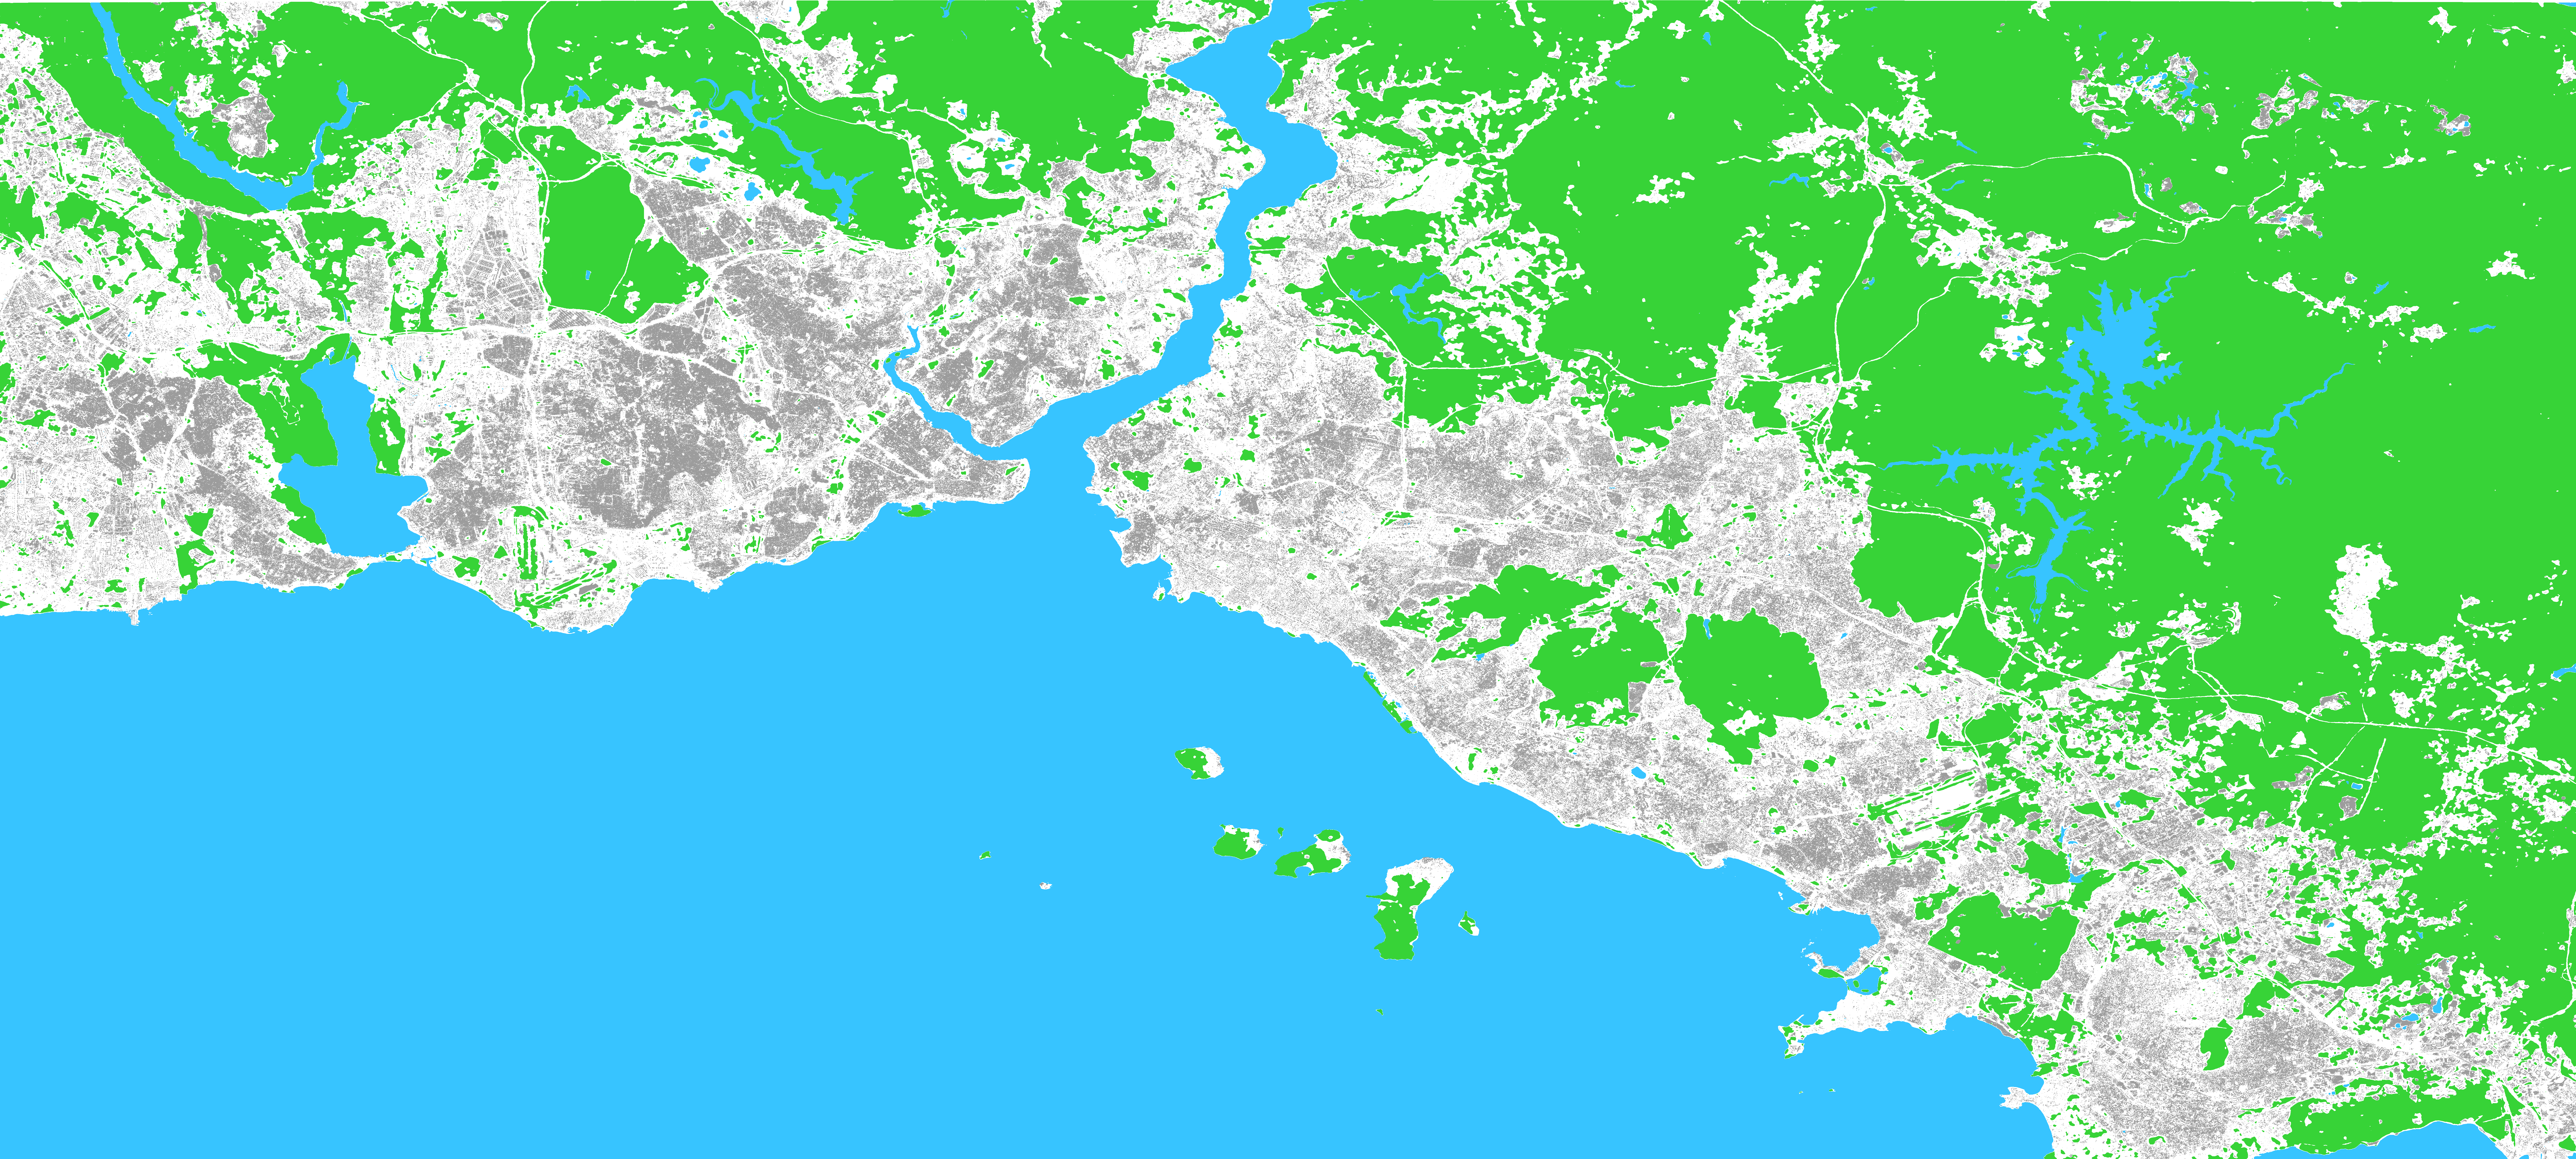

Not: Referans TIFF bulunmadığı için bu yalnızca georefsiz önizleme.


In [ ]:
# ===== Stitch tiles -> GeoTIFF (with georef) + Folium preview =====
from pathlib import Path
import re, numpy as np, rasterio
from rasterio.windows import Window
from rasterio.transform import Affine
import folium, base64, io
from PIL import Image

# ------------- PATHS -------------
DRIVE = Path("/content/drive/MyDrive")
TILES_DIR = DRIVE / "greenVSgrey_temporal_infer_tplus1"   # .npy çıktılarının klasörü
REF_TIF  = DRIVE / "greenVSgrey_models" / "aoi_reference.tif"  # AOI'yi kaplayan referans raster (S2 kompoziti gibi)
OUT_GTIFF = DRIVE / "greenVSgrey_temporal_infer_tplus1" / "tplus1_mosaic.tif"

assert any(TILES_DIR.glob("*_tplus1.npy")), f"Mask tile bulunamadı: {TILES_DIR}"

# ------------- PARSE & GROUP -------------
stem_re = re.compile(r"\d{4}_Q[1-4]_(?P<r>\d{5})_(?P<c>\d{5})_tplus1")
tiles = []
for fp in sorted(TILES_DIR.glob("*_tplus1.npy")):
    m = stem_re.match(fp.stem)
    if not m:
        continue
    r = int(m.group("r"))
    c = int(m.group("c"))
    tiles.append((r, c, fp))

assert tiles, "Hiç karo ayrıştırılamadı."

# Boyutları öğren
sample = np.load(tiles[0][2])
th, tw = sample.shape  # tile h,w

# ------------- 1) GeoTIFF'e dik (tercihli, REF_TIF varsa) -------------
if REF_TIF.exists():
    with rasterio.open(REF_TIF) as src:
        profile = src.profile
        H, W = src.height, src.width
        transform = src.transform
        crs = src.crs

    # Çıkış profili: tek bant, uint8
    profile_out = profile.copy()
    profile_out.update(count=1, dtype="uint8", nodata=255)

    OUT_GTIFF.parent.mkdir(parents=True, exist_ok=True)
    with rasterio.open(OUT_GTIFF, "w", **profile_out) as dst:
        # Başta nodata ile doldur
        dst.write(np.full((H, W), 255, dtype=np.uint8), 1)

        # Her karoyu doğru pencereye yaz
        for r, c, fp in tiles:
            # DİKKAT: r,c değerleri piksel ofsetiyse doğrudan Window’a girer.
            # Eğer r,c 'tile index' ise Window(r*th, c*tw, ...) şeklinde çevir.
            # Biz senin isimlendirmende r/c'nin piksel ofset olduğunu kullandık.
            arr = np.load(fp).astype(np.uint8)
            assert arr.shape == (th, tw), f"Tile boyutu uyuşmuyor: {fp.name}"
            win = Window(col_off=c, row_off=r, width=tw, height=th)
            dst.write(arr, 1, window=win)

    print(f"✓ GeoTIFF yazıldı: {OUT_GTIFF}")

    # ------------- 2) Folium haritasında göster (renkli overlay) -------------
    # Palet
    palette = {
        0: (0, 0, 0, 0),        # bg -> şeffaf
        1: (0, 200, 0, 160),    # green
        2: (130, 130, 130, 160),# grey
        3: (0, 180, 255, 160),  # water
        255: (0,0,0,0)          # nodata şeffaf
    }

    # Renkli PNG oluştur
    with rasterio.open(OUT_GTIFF) as ds:
        mask = ds.read(1)
        h, w = mask.shape
        rgba = np.zeros((h, w, 4), dtype=np.uint8)
        for k, col in palette.items():
            rgba[mask == k] = col
        # Bounds (latlon)
        left, bottom, right, top = ds.bounds
        bounds = [[bottom, left], [top, right]]

    # PNG'yi belleğe yaz
    buf = io.BytesIO()
    Image.fromarray(rgba, mode="RGBA").save(buf, format="PNG")
    data = base64.b64encode(buf.getvalue()).decode("utf-8")
    url = f"data:image/png;base64,{data}"

    # Harita
    center = [(bounds[0][0]+bounds[1][0])/2, (bounds[0][1]+bounds[1][1])/2]
    m = folium.Map(location=center, zoom_start=12, tiles="CartoDB positron")
    folium.raster_layers.ImageOverlay(
        image=url,
        bounds=bounds,
        opacity=0.75,
        name="t+1 prediction"
    ).add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    display(m)

else:
    # ---- Referans yoksa: georefsiz mozaik PNG (hızlı önizleme) ----
    # row/col değerleri 'piksel ofseti' ise mozaik boyutu:
    max_r = max(r for r,_,_ in tiles); max_c = max(c for _,c,_ in tiles)
    H_tot = max_r + th
    W_tot = max_c + tw
    mosaic = np.full((H_tot, W_tot), 255, dtype=np.uint8)
    for r, c, fp in tiles:
        arr = np.load(fp).astype(np.uint8)
        mosaic[r:r+th, c:c+tw] = arr

    # renkli PNG
    palette = {
        0: (0,0,0,0), 1: (0,200,0,200), 2:(130,130,130,200), 3:(0,180,255,200), 255:(0,0,0,0)
    }
    rgba = np.zeros((H_tot, W_tot, 4), dtype=np.uint8)
    for k, col in palette.items():
        rgba[mosaic == k] = col
    Image.fromarray(rgba, "RGBA")
    display(Image.fromarray(rgba, "RGBA"))
    print("Not: Referans TIFF bulunmadığı için bu yalnızca georefsiz önizleme.")
